In [1]:
"""
SUMMARY:
Dbpedia 14 class/topic classification

Accuracy: 0.991
Time per Epoch: 3403 seconds = 170 rev/s
Total time: 33883 seconds = 564 min = 9.5 hours
Train size = 560,000 
Test size = 70,000

DETAILS:
Attempt to replicate crepe model using MXNET:
https://github.com/zhangxiangxiao/Crepe

This uses an efficient numpy array (dtype=bool)
to hold all data in RAM. 

Run on one GPUs (Tesla K80) with batch=128
Peak RAM: 60GB
"""

'\nSUMMARY:\nDbpedia 14 class/topic classification\n\nAccuracy: X\nTime per Epoch: X seconds = X rev/s\nTotal time: X*10 = X min = X hours\nTrain size = 560,000 \nTest size = 70,000\n\nDETAILS:\nAttempt to replicate crepe model using MXNET:\nhttps://github.com/zhangxiangxiao/Crepe\n\nThis uses an efficient numpy array (dtype=bool)\nto hold all data in RAM. \n\nRun on 1 GPUs (Tesla K80) with batch=128\nPeak RAM: X\n'

In [2]:
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
import mxnet as mx
import wget
import time
import os.path
import math
import matplotlib.pyplot as plt
import logging

In [3]:
AZ_ACC = "amazonsentimenik"
AZ_CONTAINER = "textclassificationdatasets"

ALPHABET = list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+ =<>()[]{}")
FEATURE_LEN = 1014
BATCH_SIZE = 128
NUM_FILTERS = 256
DATA_SHAPE = (BATCH_SIZE, 1, FEATURE_LEN, len(ALPHABET))

ctx = mx.gpu(2)
EPOCHS = 10
SD = 0.05  # std for gaussian distribution
NOUTPUT = 14  # Classes
INITY = mx.init.Normal(sigma=SD)
LR = 0.01
MOMENTUM = 0.9
WDECAY = 0.00001

In [4]:
# logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='crepe_dbp.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [5]:
def download_file(url):
    # Create file-name
    local_filename = url.split('/')[-1]
    if os.path.isfile(local_filename):
        pass
        # print("The file %s already exist in the current directory\n" % local_filename)
    else:
        # Download
        print("downloading ...\n")
        wget.download(url)
        print('\nsaved data')

In [6]:
def load_data_frame(infile, shuffle = False):
    print("processing data frame: %s" % infile)
    # Get data from windows blob
    download_file('https://%s.blob.core.windows.net/%s/%s' % (AZ_ACC, AZ_CONTAINER, infile))
        # load data into dataframe
    df = pd.read_csv(infile,
                     header=None,
                     names=['sentiment', 'summary', 'text'])
    # concat summary, review; trim to 1014 char; reverse; lower
    df['rev'] = df.apply(lambda x: "%s %s" % (x['summary'], x['text']), axis=1)
    df.rev = df.rev.str[:FEATURE_LEN].str[::-1].str.lower()
    # store class as nparray
    df.sentiment -= 1
    y_split = np.asarray(df.sentiment, dtype='int')
    # drop columns
    df.drop(['text', 'summary', 'sentiment'], axis=1, inplace=True)
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    # Dictionary to create character vectors
    character_hash = pd.DataFrame(np.identity(len(ALPHABET), dtype='bool'), columns=ALPHABET)
    print("finished processing data frame: %s" % infile)
    print("data contains %d obs" % df.shape[0])
    batch_size = df.shape[0]
    # Create encoding
    X_split = np.zeros([batch_size, 1, FEATURE_LEN, len(ALPHABET)], dtype='bool')
    # Main loop
    for ti, tx in enumerate(df.rev):
        if (ti+1) % (100*1000) == 0:
            print("Processed: ", ti+1)
        chars = list(tx)
        for ci, ch in enumerate(chars):
            if ch in ALPHABET:
                X_split[ti % batch_size][0][ci] = np.array(character_hash[ch], dtype='bool')
                
    # Return as a DataBatch
    #return DataBatch(data=[mx.nd.array(X_split)],
    #                 label=[mx.nd.array(y_split[ti + 1 - batch_size:ti + 1])])
    return X_split, y_split

In [7]:
def create_crepe():
    """
    Replicating: https://github.com/zhangxiangxiao/Crepe/blob/master/train/config.lua
    """
    input_x = mx.sym.Variable('data')  # placeholder for input
    input_y = mx.sym.Variable('softmax_label')  # placeholder for output
    # 1. alphabet x 1014
    conv1 = mx.symbol.Convolution(
        data=input_x, kernel=(7, 69), num_filter=NUM_FILTERS)
    relu1 = mx.symbol.Activation(
        data=conv1, act_type="relu")
    pool1 = mx.symbol.Pooling(
        data=relu1, pool_type="max", kernel=(3, 1), stride=(3, 1))
    # 2. 336 x 256
    conv2 = mx.symbol.Convolution(
        data=pool1, kernel=(7, 1), num_filter=NUM_FILTERS)
    relu2 = mx.symbol.Activation(
        data=conv2, act_type="relu")
    pool2 = mx.symbol.Pooling(
        data=relu2, pool_type="max", kernel=(3, 1), stride=(3, 1))
    # 3. 110 x 256
    conv3 = mx.symbol.Convolution(
        data=pool2, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu3 = mx.symbol.Activation(
        data=conv3, act_type="relu")
    # 4. 108 x 256
    conv4 = mx.symbol.Convolution(
        data=relu3, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu4 = mx.symbol.Activation(
        data=conv4, act_type="relu")
    # 5. 106 x 256
    conv5 = mx.symbol.Convolution(
        data=relu4, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu5 = mx.symbol.Activation(
        data=conv5, act_type="relu")
    # 6. 104 x 256
    conv6 = mx.symbol.Convolution(
        data=relu5, kernel=(3, 1), num_filter=NUM_FILTERS)
    relu6 = mx.symbol.Activation(
        data=conv6, act_type="relu")
    pool6 = mx.symbol.Pooling(
        data=relu6, pool_type="max", kernel=(3, 1), stride=(3, 1))
    # 34 x 256
    flatten = mx.symbol.Flatten(data=pool6)
    # 7.  8704
    fc1 = mx.symbol.FullyConnected(
        data=flatten, num_hidden=1024)
    act_fc1 = mx.symbol.Activation(
        data=fc1, act_type="relu")
    drop1 = mx.sym.Dropout(act_fc1, p=0.5)
    # 8. 1024
    fc2 = mx.symbol.FullyConnected(
        data=drop1, num_hidden=1024)
    act_fc2 = mx.symbol.Activation(
        data=fc2, act_type="relu")
    drop2 = mx.sym.Dropout(act_fc2, p=0.5)
    # 9. 1024
    fc3 = mx.symbol.FullyConnected(
        data=drop2, num_hidden=NOUTPUT)
    crepe = mx.symbol.SoftmaxOutput(
        data=fc3, label=input_y, name="softmax")
    return crepe

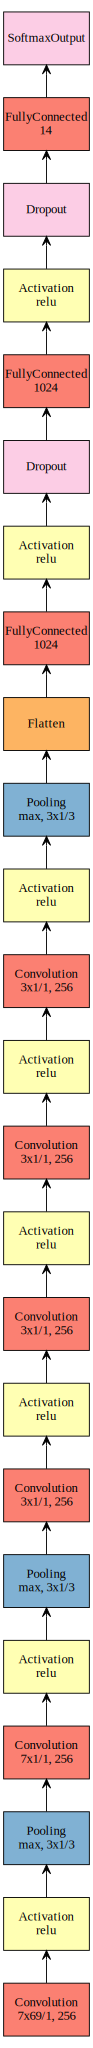

In [8]:
# Visualise symbol (for crepe)
crepe = create_crepe()

a = mx.viz.plot_network(crepe)
a.render('Crepe Model')
a

In [9]:
train_x, train_y = load_data_frame('dbpedia_train.csv')

processing data frame: dbpedia_train.csv
finished processing data frame: dbpedia_train.csv
data contains 560000 obs
('Processed: ', 100000)
('Processed: ', 200000)
('Processed: ', 300000)
('Processed: ', 400000)
('Processed: ', 500000)


In [10]:
test_x, test_y = load_data_frame('dbpedia_test.csv')

processing data frame: dbpedia_test.csv
finished processing data frame: dbpedia_test.csv
data contains 70000 obs


In [11]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(560000L, 1L, 1014L, 69L)
(560000L,)
(70000L, 1L, 1014L, 69L)
(70000L,)


In [12]:
train_iter = mx.io.NDArrayIter(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
test_iter = mx.io.NDArrayIter(test_x, test_y, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
del train_x
del train_y
del test_x

In [15]:
model = mx.model.FeedForward(
    ctx = ctx,
    symbol = create_crepe(), 
    num_epoch = EPOCHS,  # number of training rounds
    learning_rate = LR,  # learning rate
    momentum = MOMENTUM,   # momentum for sgd
    wd = WDECAY,  # weight decay for reg
    initializer = INITY  # init with sd of 0.05
)

In [16]:
tic = time.time()
model.fit(
    X = train_iter,
    eval_metric=['accuracy'],
    batch_end_callback=mx.callback.Speedometer(BATCH_SIZE),
    epoch_end_callback=mx.callback.do_checkpoint("crepe_dbp_chck_") 
)
print("Finished training in %.0f seconds" % (time.time() - tic))

Finished training in 33883 seconds


In [17]:
# Predict
pred = np.argsort(model.predict(X = test_iter))[:,-1]

# Save Results
np.savetxt('crepe_predict_class_dbpedia.csv', np.c_[pred, test_y], delimiter=',', fmt='%d')

In [18]:
# Accuracy
acc = sum(pred==test_y.astype('int'))/float(len(test_y))
logger.info(acc)
acc 

0.99058571428571429

### Log


```
2016-08-30 00:37:37,993 - root - INFO - Start training with [gpu(2)]
2016-08-30 00:38:48,349 - root - INFO - Epoch[0] Batch [50]	Speed: 123.69 samples/sec	Train-accuracy=0.911563
2016-08-30 00:39:32,703 - root - INFO - Epoch[0] Batch [100]	Speed: 144.30 samples/sec	Train-accuracy=0.926875
2016-08-30 00:40:14,904 - root - INFO - Epoch[0] Batch [150]	Speed: 151.65 samples/sec	Train-accuracy=0.931875
2016-08-30 00:40:55,510 - root - INFO - Epoch[0] Batch [200]	Speed: 157.61 samples/sec	Train-accuracy=0.926406
2016-08-30 00:41:36,693 - root - INFO - Epoch[0] Batch [250]	Speed: 155.41 samples/sec	Train-accuracy=0.928281
2016-08-30 00:42:19,690 - root - INFO - Epoch[0] Batch [300]	Speed: 148.84 samples/sec	Train-accuracy=0.926562
2016-08-30 00:42:59,351 - root - INFO - Epoch[0] Batch [350]	Speed: 161.37 samples/sec	Train-accuracy=0.929375
2016-08-30 00:43:39,203 - root - INFO - Epoch[0] Batch [400]	Speed: 160.59 samples/sec	Train-accuracy=0.930156
2016-08-30 00:44:16,867 - root - INFO - Epoch[0] Batch [450]	Speed: 170.00 samples/sec	Train-accuracy=0.931875
2016-08-30 00:44:56,917 - root - INFO - Epoch[0] Batch [500]	Speed: 159.80 samples/sec	Train-accuracy=0.928438
2016-08-30 00:45:35,947 - root - INFO - Epoch[0] Batch [550]	Speed: 163.98 samples/sec	Train-accuracy=0.930312
2016-08-30 00:46:16,690 - root - INFO - Epoch[0] Batch [600]	Speed: 157.09 samples/sec	Train-accuracy=0.923281
2016-08-30 00:46:54,801 - root - INFO - Epoch[0] Batch [650]	Speed: 167.93 samples/sec	Train-accuracy=0.925781
2016-08-30 00:47:34,842 - root - INFO - Epoch[0] Batch [700]	Speed: 159.84 samples/sec	Train-accuracy=0.932969
2016-08-30 00:48:16,367 - root - INFO - Epoch[0] Batch [750]	Speed: 154.12 samples/sec	Train-accuracy=0.927344
2016-08-30 00:48:56,364 - root - INFO - Epoch[0] Batch [800]	Speed: 160.01 samples/sec	Train-accuracy=0.931875
2016-08-30 00:49:37,109 - root - INFO - Epoch[0] Batch [850]	Speed: 157.13 samples/sec	Train-accuracy=0.926875
2016-08-30 00:50:17,088 - root - INFO - Epoch[0] Batch [900]	Speed: 160.09 samples/sec	Train-accuracy=0.924375
2016-08-30 00:50:56,134 - root - INFO - Epoch[0] Batch [950]	Speed: 163.91 samples/sec	Train-accuracy=0.932500
2016-08-30 00:51:38,210 - root - INFO - Epoch[0] Batch [1000]	Speed: 152.11 samples/sec	Train-accuracy=0.930469
2016-08-30 00:52:18,025 - root - INFO - Epoch[0] Batch [1050]	Speed: 160.75 samples/sec	Train-accuracy=0.939375
2016-08-30 00:52:57,459 - root - INFO - Epoch[0] Batch [1100]	Speed: 162.30 samples/sec	Train-accuracy=0.947344
2016-08-30 00:53:37,292 - root - INFO - Epoch[0] Batch [1150]	Speed: 160.67 samples/sec	Train-accuracy=0.953438
2016-08-30 00:54:15,290 - root - INFO - Epoch[0] Batch [1200]	Speed: 168.43 samples/sec	Train-accuracy=0.950781
2016-08-30 00:54:54,750 - root - INFO - Epoch[0] Batch [1250]	Speed: 162.19 samples/sec	Train-accuracy=0.961875
2016-08-30 00:55:31,630 - root - INFO - Epoch[0] Batch [1300]	Speed: 173.54 samples/sec	Train-accuracy=0.965781
2016-08-30 00:56:12,480 - root - INFO - Epoch[0] Batch [1350]	Speed: 156.67 samples/sec	Train-accuracy=0.958750
2016-08-30 00:56:50,193 - root - INFO - Epoch[0] Batch [1400]	Speed: 169.70 samples/sec	Train-accuracy=0.962344
2016-08-30 00:57:31,249 - root - INFO - Epoch[0] Batch [1450]	Speed: 155.88 samples/sec	Train-accuracy=0.964844
2016-08-30 00:58:07,599 - root - INFO - Epoch[0] Batch [1500]	Speed: 176.06 samples/sec	Train-accuracy=0.965625
2016-08-30 00:58:46,717 - root - INFO - Epoch[0] Batch [1550]	Speed: 163.61 samples/sec	Train-accuracy=0.966562
2016-08-30 00:59:25,177 - root - INFO - Epoch[0] Batch [1600]	Speed: 166.41 samples/sec	Train-accuracy=0.973437
2016-08-30 01:00:03,180 - root - INFO - Epoch[0] Batch [1650]	Speed: 168.40 samples/sec	Train-accuracy=0.968125
2016-08-30 01:00:44,380 - root - INFO - Epoch[0] Batch [1700]	Speed: 155.40 samples/sec	Train-accuracy=0.973125
2016-08-30 01:01:22,089 - root - INFO - Epoch[0] Batch [1750]	Speed: 169.72 samples/sec	Train-accuracy=0.976406
2016-08-30 01:02:01,825 - root - INFO - Epoch[0] Batch [1800]	Speed: 161.06 samples/sec	Train-accuracy=0.969531
2016-08-30 01:02:41,585 - root - INFO - Epoch[0] Batch [1850]	Speed: 160.97 samples/sec	Train-accuracy=0.974063
2016-08-30 01:03:20,986 - root - INFO - Epoch[0] Batch [1900]	Speed: 162.43 samples/sec	Train-accuracy=0.980938
2016-08-30 01:03:58,926 - root - INFO - Epoch[0] Batch [1950]	Speed: 168.69 samples/sec	Train-accuracy=0.973750
2016-08-30 01:04:38,700 - root - INFO - Epoch[0] Batch [2000]	Speed: 160.91 samples/sec	Train-accuracy=0.981094
2016-08-30 01:05:17,927 - root - INFO - Epoch[0] Batch [2050]	Speed: 163.15 samples/sec	Train-accuracy=0.978125
2016-08-30 01:05:56,730 - root - INFO - Epoch[0] Batch [2100]	Speed: 164.94 samples/sec	Train-accuracy=0.972812
2016-08-30 01:06:35,349 - root - INFO - Epoch[0] Batch [2150]	Speed: 165.72 samples/sec	Train-accuracy=0.981719
2016-08-30 01:07:16,963 - root - INFO - Epoch[0] Batch [2200]	Speed: 153.80 samples/sec	Train-accuracy=0.979219
2016-08-30 01:07:55,216 - root - INFO - Epoch[0] Batch [2250]	Speed: 167.31 samples/sec	Train-accuracy=0.983281
2016-08-30 01:08:35,470 - root - INFO - Epoch[0] Batch [2300]	Speed: 158.99 samples/sec	Train-accuracy=0.977031
2016-08-30 01:09:15,009 - root - INFO - Epoch[0] Batch [2350]	Speed: 161.87 samples/sec	Train-accuracy=0.981563
2016-08-30 01:09:50,249 - root - INFO - Epoch[0] Batch [2400]	Speed: 181.70 samples/sec	Train-accuracy=0.960625
2016-08-30 01:10:27,190 - root - INFO - Epoch[0] Batch [2450]	Speed: 173.24 samples/sec	Train-accuracy=0.980938
2016-08-30 01:11:05,828 - root - INFO - Epoch[0] Batch [2500]	Speed: 165.71 samples/sec	Train-accuracy=0.979375
2016-08-30 01:11:43,872 - root - INFO - Epoch[0] Batch [2550]	Speed: 168.22 samples/sec	Train-accuracy=0.983750
2016-08-30 01:12:22,782 - root - INFO - Epoch[0] Batch [2600]	Speed: 164.49 samples/sec	Train-accuracy=0.985156
2016-08-30 01:13:01,819 - root - INFO - Epoch[0] Batch [2650]	Speed: 163.94 samples/sec	Train-accuracy=0.978281
2016-08-30 01:13:41,121 - root - INFO - Epoch[0] Batch [2700]	Speed: 162.85 samples/sec	Train-accuracy=0.980000
2016-08-30 01:14:20,746 - root - INFO - Epoch[0] Batch [2750]	Speed: 161.51 samples/sec	Train-accuracy=0.982656
2016-08-30 01:14:58,612 - root - INFO - Epoch[0] Batch [2800]	Speed: 169.01 samples/sec	Train-accuracy=0.977969
2016-08-30 01:15:38,345 - root - INFO - Epoch[0] Batch [2850]	Speed: 161.08 samples/sec	Train-accuracy=0.985625
2016-08-30 01:16:17,599 - root - INFO - Epoch[0] Batch [2900]	Speed: 163.04 samples/sec	Train-accuracy=0.984531
2016-08-30 01:16:55,703 - root - INFO - Epoch[0] Batch [2950]	Speed: 167.96 samples/sec	Train-accuracy=0.981563
2016-08-30 01:17:34,858 - root - INFO - Epoch[0] Batch [3000]	Speed: 163.45 samples/sec	Train-accuracy=0.979844
2016-08-30 01:18:10,746 - root - INFO - Epoch[0] Batch [3050]	Speed: 178.33 samples/sec	Train-accuracy=0.978437
2016-08-30 01:18:49,516 - root - INFO - Epoch[0] Batch [3100]	Speed: 165.08 samples/sec	Train-accuracy=0.984375
2016-08-30 01:19:31,230 - root - INFO - Epoch[0] Batch [3150]	Speed: 153.42 samples/sec	Train-accuracy=0.984688
2016-08-30 01:20:10,056 - root - INFO - Epoch[0] Batch [3200]	Speed: 164.84 samples/sec	Train-accuracy=0.987031
2016-08-30 01:20:49,296 - root - INFO - Epoch[0] Batch [3250]	Speed: 163.10 samples/sec	Train-accuracy=0.983750
2016-08-30 01:21:27,516 - root - INFO - Epoch[0] Batch [3300]	Speed: 167.45 samples/sec	Train-accuracy=0.986406
2016-08-30 01:22:07,170 - root - INFO - Epoch[0] Batch [3350]	Speed: 161.40 samples/sec	Train-accuracy=0.985156
2016-08-30 01:22:46,355 - root - INFO - Epoch[0] Batch [3400]	Speed: 163.32 samples/sec	Train-accuracy=0.983437
2016-08-30 01:23:25,025 - root - INFO - Epoch[0] Batch [3450]	Speed: 165.51 samples/sec	Train-accuracy=0.987812
2016-08-30 01:24:04,188 - root - INFO - Epoch[0] Batch [3500]	Speed: 163.42 samples/sec	Train-accuracy=0.986563
2016-08-30 01:24:45,484 - root - INFO - Epoch[0] Batch [3550]	Speed: 154.98 samples/sec	Train-accuracy=0.985313
2016-08-30 01:25:25,098 - root - INFO - Epoch[0] Batch [3600]	Speed: 161.56 samples/sec	Train-accuracy=0.987031
2016-08-30 01:26:04,048 - root - INFO - Epoch[0] Batch [3650]	Speed: 164.31 samples/sec	Train-accuracy=0.985313
2016-08-30 01:26:43,332 - root - INFO - Epoch[0] Batch [3700]	Speed: 162.91 samples/sec	Train-accuracy=0.986094
2016-08-30 01:27:21,500 - root - INFO - Epoch[0] Batch [3750]	Speed: 167.68 samples/sec	Train-accuracy=0.986563
2016-08-30 01:27:59,355 - root - INFO - Epoch[0] Batch [3800]	Speed: 169.07 samples/sec	Train-accuracy=0.978594
2016-08-30 01:28:38,845 - root - INFO - Epoch[0] Batch [3850]	Speed: 162.07 samples/sec	Train-accuracy=0.986719
2016-08-30 01:29:19,246 - root - INFO - Epoch[0] Batch [3900]	Speed: 158.41 samples/sec	Train-accuracy=0.979688
2016-08-30 01:29:58,006 - root - INFO - Epoch[0] Batch [3950]	Speed: 165.12 samples/sec	Train-accuracy=0.989688
2016-08-30 01:30:36,457 - root - INFO - Epoch[0] Batch [4000]	Speed: 166.44 samples/sec	Train-accuracy=0.986406
2016-08-30 01:31:15,694 - root - INFO - Epoch[0] Batch [4050]	Speed: 163.11 samples/sec	Train-accuracy=0.988594
2016-08-30 01:31:56,598 - root - INFO - Epoch[0] Batch [4100]	Speed: 156.47 samples/sec	Train-accuracy=0.985781
2016-08-30 01:32:34,127 - root - INFO - Epoch[0] Batch [4150]	Speed: 170.53 samples/sec	Train-accuracy=0.986563
2016-08-30 01:33:13,602 - root - INFO - Epoch[0] Batch [4200]	Speed: 162.12 samples/sec	Train-accuracy=0.987344
2016-08-30 01:33:52,529 - root - INFO - Epoch[0] Batch [4250]	Speed: 164.41 samples/sec	Train-accuracy=0.986250
2016-08-30 01:34:30,102 - root - INFO - Epoch[0] Batch [4300]	Speed: 170.33 samples/sec	Train-accuracy=0.985938
2016-08-30 01:35:08,796 - root - INFO - Epoch[0] Batch [4350]	Speed: 165.40 samples/sec	Train-accuracy=0.988594
2016-08-30 01:35:28,500 - root - INFO - Epoch[0] Resetting Data Iterator
2016-08-30 01:35:28,500 - root - INFO - Epoch[0] Time cost=3463.343
2016-08-30 01:35:29,484 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0001.params"
2016-08-30 01:36:06,661 - root - INFO - Epoch[1] Batch [50]	Speed: 173.03 samples/sec	Train-accuracy=0.988125
2016-08-30 01:36:45,680 - root - INFO - Epoch[1] Batch [100]	Speed: 164.02 samples/sec	Train-accuracy=0.987031
2016-08-30 01:37:23,836 - root - INFO - Epoch[1] Batch [150]	Speed: 167.73 samples/sec	Train-accuracy=0.987500
2016-08-30 01:38:03,131 - root - INFO - Epoch[1] Batch [200]	Speed: 162.87 samples/sec	Train-accuracy=0.989531
2016-08-30 01:38:42,428 - root - INFO - Epoch[1] Batch [250]	Speed: 162.86 samples/sec	Train-accuracy=0.986875
2016-08-30 01:39:20,832 - root - INFO - Epoch[1] Batch [300]	Speed: 166.65 samples/sec	Train-accuracy=0.983906
2016-08-30 01:39:58,486 - root - INFO - Epoch[1] Batch [350]	Speed: 169.97 samples/sec	Train-accuracy=0.989844
2016-08-30 01:40:40,115 - root - INFO - Epoch[1] Batch [400]	Speed: 153.74 samples/sec	Train-accuracy=0.990781
2016-08-30 01:41:18,519 - root - INFO - Epoch[1] Batch [450]	Speed: 166.64 samples/sec	Train-accuracy=0.989219
2016-08-30 01:41:56,562 - root - INFO - Epoch[1] Batch [500]	Speed: 168.24 samples/sec	Train-accuracy=0.986563
2016-08-30 01:42:34,545 - root - INFO - Epoch[1] Batch [550]	Speed: 168.63 samples/sec	Train-accuracy=0.992969
2016-08-30 01:43:13,253 - root - INFO - Epoch[1] Batch [600]	Speed: 165.34 samples/sec	Train-accuracy=0.988750
2016-08-30 01:43:51,536 - root - INFO - Epoch[1] Batch [650]	Speed: 167.17 samples/sec	Train-accuracy=0.990469
2016-08-30 01:44:29,398 - root - INFO - Epoch[1] Batch [700]	Speed: 169.03 samples/sec	Train-accuracy=0.987656
2016-08-30 01:45:11,043 - root - INFO - Epoch[1] Batch [750]	Speed: 153.68 samples/sec	Train-accuracy=0.991250
2016-08-30 01:45:48,905 - root - INFO - Epoch[1] Batch [800]	Speed: 169.03 samples/sec	Train-accuracy=0.990938
2016-08-30 01:46:27,500 - root - INFO - Epoch[1] Batch [850]	Speed: 165.82 samples/sec	Train-accuracy=0.991875
2016-08-30 01:47:05,450 - root - INFO - Epoch[1] Batch [900]	Speed: 168.65 samples/sec	Train-accuracy=0.983750
2016-08-30 01:47:43,536 - root - INFO - Epoch[1] Batch [950]	Speed: 168.04 samples/sec	Train-accuracy=0.987656
2016-08-30 01:48:19,869 - root - INFO - Epoch[1] Batch [1000]	Speed: 176.15 samples/sec	Train-accuracy=0.986719
2016-08-30 01:48:55,717 - root - INFO - Epoch[1] Batch [1050]	Speed: 178.53 samples/sec	Train-accuracy=0.990156
2016-08-30 01:49:32,053 - root - INFO - Epoch[1] Batch [1100]	Speed: 176.13 samples/sec	Train-accuracy=0.987031
2016-08-30 01:50:08,917 - root - INFO - Epoch[1] Batch [1150]	Speed: 173.61 samples/sec	Train-accuracy=0.986406
2016-08-30 01:50:45,595 - root - INFO - Epoch[1] Batch [1200]	Speed: 174.50 samples/sec	Train-accuracy=0.991719
2016-08-30 01:51:21,542 - root - INFO - Epoch[1] Batch [1250]	Speed: 178.04 samples/sec	Train-accuracy=0.990469
2016-08-30 01:51:59,391 - root - INFO - Epoch[1] Batch [1300]	Speed: 169.09 samples/sec	Train-accuracy=0.988437
2016-08-30 01:52:36,301 - root - INFO - Epoch[1] Batch [1350]	Speed: 173.39 samples/sec	Train-accuracy=0.990313
2016-08-30 01:53:11,111 - root - INFO - Epoch[1] Batch [1400]	Speed: 183.86 samples/sec	Train-accuracy=0.989531
2016-08-30 01:53:49,384 - root - INFO - Epoch[1] Batch [1450]	Speed: 167.22 samples/sec	Train-accuracy=0.989219
2016-08-30 01:54:28,522 - root - INFO - Epoch[1] Batch [1500]	Speed: 163.53 samples/sec	Train-accuracy=0.990938
2016-08-30 01:55:08,404 - root - INFO - Epoch[1] Batch [1550]	Speed: 160.47 samples/sec	Train-accuracy=0.988281
2016-08-30 01:55:48,089 - root - INFO - Epoch[1] Batch [1600]	Speed: 161.27 samples/sec	Train-accuracy=0.988437
2016-08-30 01:56:26,792 - root - INFO - Epoch[1] Batch [1650]	Speed: 165.37 samples/sec	Train-accuracy=0.993750
2016-08-30 01:57:05,956 - root - INFO - Epoch[1] Batch [1700]	Speed: 163.42 samples/sec	Train-accuracy=0.991094
2016-08-30 01:57:44,796 - root - INFO - Epoch[1] Batch [1750]	Speed: 164.78 samples/sec	Train-accuracy=0.988437
2016-08-30 01:58:23,163 - root - INFO - Epoch[1] Batch [1800]	Speed: 166.81 samples/sec	Train-accuracy=0.990313
2016-08-30 01:59:00,183 - root - INFO - Epoch[1] Batch [1850]	Speed: 172.88 samples/sec	Train-accuracy=0.986719
2016-08-30 01:59:39,088 - root - INFO - Epoch[1] Batch [1900]	Speed: 164.50 samples/sec	Train-accuracy=0.990469
2016-08-30 02:00:16,865 - root - INFO - Epoch[1] Batch [1950]	Speed: 169.42 samples/sec	Train-accuracy=0.988281
2016-08-30 02:00:56,535 - root - INFO - Epoch[1] Batch [2000]	Speed: 161.33 samples/sec	Train-accuracy=0.988281
2016-08-30 02:01:37,240 - root - INFO - Epoch[1] Batch [2050]	Speed: 157.22 samples/sec	Train-accuracy=0.987500
2016-08-30 02:02:17,381 - root - INFO - Epoch[1] Batch [2100]	Speed: 159.44 samples/sec	Train-accuracy=0.992812
2016-08-30 02:02:57,042 - root - INFO - Epoch[1] Batch [2150]	Speed: 161.37 samples/sec	Train-accuracy=0.990156
2016-08-30 02:03:35,223 - root - INFO - Epoch[1] Batch [2200]	Speed: 167.62 samples/sec	Train-accuracy=0.990781
2016-08-30 02:04:13,709 - root - INFO - Epoch[1] Batch [2250]	Speed: 166.30 samples/sec	Train-accuracy=0.991563
2016-08-30 02:04:50,901 - root - INFO - Epoch[1] Batch [2300]	Speed: 172.08 samples/sec	Train-accuracy=0.990781
2016-08-30 02:05:30,822 - root - INFO - Epoch[1] Batch [2350]	Speed: 160.32 samples/sec	Train-accuracy=0.992656
2016-08-30 02:06:08,881 - root - INFO - Epoch[1] Batch [2400]	Speed: 168.16 samples/sec	Train-accuracy=0.990781
2016-08-30 02:06:48,049 - root - INFO - Epoch[1] Batch [2450]	Speed: 163.40 samples/sec	Train-accuracy=0.991094
2016-08-30 02:07:25,043 - root - INFO - Epoch[1] Batch [2500]	Speed: 173.00 samples/sec	Train-accuracy=0.991875
2016-08-30 02:08:03,881 - root - INFO - Epoch[1] Batch [2550]	Speed: 164.79 samples/sec	Train-accuracy=0.991250
2016-08-30 02:08:41,953 - root - INFO - Epoch[1] Batch [2600]	Speed: 168.11 samples/sec	Train-accuracy=0.991563
2016-08-30 02:09:22,456 - root - INFO - Epoch[1] Batch [2650]	Speed: 158.01 samples/sec	Train-accuracy=0.990156
2016-08-30 02:10:02,621 - root - INFO - Epoch[1] Batch [2700]	Speed: 159.34 samples/sec	Train-accuracy=0.993906
2016-08-30 02:10:42,980 - root - INFO - Epoch[1] Batch [2750]	Speed: 158.58 samples/sec	Train-accuracy=0.991719
2016-08-30 02:11:21,398 - root - INFO - Epoch[1] Batch [2800]	Speed: 166.59 samples/sec	Train-accuracy=0.988750
2016-08-30 02:11:58,565 - root - INFO - Epoch[1] Batch [2850]	Speed: 172.19 samples/sec	Train-accuracy=0.992031
2016-08-30 02:12:36,496 - root - INFO - Epoch[1] Batch [2900]	Speed: 168.73 samples/sec	Train-accuracy=0.992031
2016-08-30 02:13:14,351 - root - INFO - Epoch[1] Batch [2950]	Speed: 169.07 samples/sec	Train-accuracy=0.991406
2016-08-30 02:13:51,671 - root - INFO - Epoch[1] Batch [3000]	Speed: 171.49 samples/sec	Train-accuracy=0.990938
2016-08-30 02:14:31,423 - root - INFO - Epoch[1] Batch [3050]	Speed: 161.00 samples/sec	Train-accuracy=0.991875
2016-08-30 02:15:11,612 - root - INFO - Epoch[1] Batch [3100]	Speed: 159.24 samples/sec	Train-accuracy=0.992344
2016-08-30 02:15:50,510 - root - INFO - Epoch[1] Batch [3150]	Speed: 164.53 samples/sec	Train-accuracy=0.991719
2016-08-30 02:16:27,430 - root - INFO - Epoch[1] Batch [3200]	Speed: 173.35 samples/sec	Train-accuracy=0.991406
2016-08-30 02:17:06,367 - root - INFO - Epoch[1] Batch [3250]	Speed: 164.37 samples/sec	Train-accuracy=0.991719
2016-08-30 02:17:46,127 - root - INFO - Epoch[1] Batch [3300]	Speed: 160.97 samples/sec	Train-accuracy=0.991563
2016-08-30 02:18:24,717 - root - INFO - Epoch[1] Batch [3350]	Speed: 165.85 samples/sec	Train-accuracy=0.991563
2016-08-30 02:19:02,503 - root - INFO - Epoch[1] Batch [3400]	Speed: 169.37 samples/sec	Train-accuracy=0.991406
2016-08-30 02:19:40,601 - root - INFO - Epoch[1] Batch [3450]	Speed: 167.99 samples/sec	Train-accuracy=0.993594
2016-08-30 02:20:17,180 - root - INFO - Epoch[1] Batch [3500]	Speed: 174.97 samples/sec	Train-accuracy=0.990469
2016-08-30 02:20:54,647 - root - INFO - Epoch[1] Batch [3550]	Speed: 170.82 samples/sec	Train-accuracy=0.989531
2016-08-30 02:21:33,595 - root - INFO - Epoch[1] Batch [3600]	Speed: 164.32 samples/sec	Train-accuracy=0.991563
2016-08-30 02:22:10,022 - root - INFO - Epoch[1] Batch [3650]	Speed: 175.70 samples/sec	Train-accuracy=0.992812
2016-08-30 02:22:50,046 - root - INFO - Epoch[1] Batch [3700]	Speed: 159.90 samples/sec	Train-accuracy=0.993437
2016-08-30 02:23:26,483 - root - INFO - Epoch[1] Batch [3750]	Speed: 175.65 samples/sec	Train-accuracy=0.990938
2016-08-30 02:24:04,941 - root - INFO - Epoch[1] Batch [3800]	Speed: 166.41 samples/sec	Train-accuracy=0.985938
2016-08-30 02:24:43,601 - root - INFO - Epoch[1] Batch [3850]	Speed: 165.55 samples/sec	Train-accuracy=0.990313
2016-08-30 02:25:20,355 - root - INFO - Epoch[1] Batch [3900]	Speed: 174.14 samples/sec	Train-accuracy=0.988906
2016-08-30 02:25:59,977 - root - INFO - Epoch[1] Batch [3950]	Speed: 161.52 samples/sec	Train-accuracy=0.993125
2016-08-30 02:26:37,391 - root - INFO - Epoch[1] Batch [4000]	Speed: 171.06 samples/sec	Train-accuracy=0.992188
2016-08-30 02:27:14,569 - root - INFO - Epoch[1] Batch [4050]	Speed: 172.14 samples/sec	Train-accuracy=0.990938
2016-08-30 02:27:51,322 - root - INFO - Epoch[1] Batch [4100]	Speed: 174.13 samples/sec	Train-accuracy=0.991250
2016-08-30 02:28:30,026 - root - INFO - Epoch[1] Batch [4150]	Speed: 165.36 samples/sec	Train-accuracy=0.989688
2016-08-30 02:29:08,078 - root - INFO - Epoch[1] Batch [4200]	Speed: 168.26 samples/sec	Train-accuracy=0.990625
2016-08-30 02:29:45,414 - root - INFO - Epoch[1] Batch [4250]	Speed: 171.42 samples/sec	Train-accuracy=0.992344
2016-08-30 02:30:24,160 - root - INFO - Epoch[1] Batch [4300]	Speed: 165.18 samples/sec	Train-accuracy=0.989375
2016-08-30 02:31:00,665 - root - INFO - Epoch[1] Batch [4350]	Speed: 175.31 samples/sec	Train-accuracy=0.992344
2016-08-30 02:31:20,207 - root - INFO - Epoch[1] Resetting Data Iterator
2016-08-30 02:31:20,207 - root - INFO - Epoch[1] Time cost=3350.722
2016-08-30 02:31:22,144 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0002.params"
2016-08-30 02:31:59,334 - root - INFO - Epoch[2] Batch [50]	Speed: 172.89 samples/sec	Train-accuracy=0.992344
2016-08-30 02:32:36,144 - root - INFO - Epoch[2] Batch [100]	Speed: 173.86 samples/sec	Train-accuracy=0.989688
2016-08-30 02:33:12,960 - root - INFO - Epoch[2] Batch [150]	Speed: 173.84 samples/sec	Train-accuracy=0.992031
2016-08-30 02:33:49,582 - root - INFO - Epoch[2] Batch [200]	Speed: 174.75 samples/sec	Train-accuracy=0.990469
2016-08-30 02:34:29,157 - root - INFO - Epoch[2] Batch [250]	Speed: 161.72 samples/sec	Train-accuracy=0.993594
2016-08-30 02:35:07,395 - root - INFO - Epoch[2] Batch [300]	Speed: 167.37 samples/sec	Train-accuracy=0.992188
2016-08-30 02:35:45,391 - root - INFO - Epoch[2] Batch [350]	Speed: 168.49 samples/sec	Train-accuracy=0.993281
2016-08-30 02:36:24,555 - root - INFO - Epoch[2] Batch [400]	Speed: 163.47 samples/sec	Train-accuracy=0.992969
2016-08-30 02:37:01,839 - root - INFO - Epoch[2] Batch [450]	Speed: 171.66 samples/sec	Train-accuracy=0.991406
2016-08-30 02:37:38,933 - root - INFO - Epoch[2] Batch [500]	Speed: 172.54 samples/sec	Train-accuracy=0.990000
2016-08-30 02:38:17,188 - root - INFO - Epoch[2] Batch [550]	Speed: 167.29 samples/sec	Train-accuracy=0.995469
2016-08-30 02:38:55,512 - root - INFO - Epoch[2] Batch [600]	Speed: 167.00 samples/sec	Train-accuracy=0.994375
2016-08-30 02:39:31,736 - root - INFO - Epoch[2] Batch [650]	Speed: 176.68 samples/sec	Train-accuracy=0.994219
2016-08-30 02:40:09,733 - root - INFO - Epoch[2] Batch [700]	Speed: 168.43 samples/sec	Train-accuracy=0.990625
2016-08-30 02:40:48,269 - root - INFO - Epoch[2] Batch [750]	Speed: 166.08 samples/sec	Train-accuracy=0.992969
2016-08-30 02:41:27,543 - root - INFO - Epoch[2] Batch [800]	Speed: 162.95 samples/sec	Train-accuracy=0.993281
2016-08-30 02:42:07,098 - root - INFO - Epoch[2] Batch [850]	Speed: 161.80 samples/sec	Train-accuracy=0.994375
2016-08-30 02:42:46,092 - root - INFO - Epoch[2] Batch [900]	Speed: 164.12 samples/sec	Train-accuracy=0.991875
2016-08-30 02:43:27,901 - root - INFO - Epoch[2] Batch [950]	Speed: 153.08 samples/sec	Train-accuracy=0.992031
2016-08-30 02:44:05,743 - root - INFO - Epoch[2] Batch [1000]	Speed: 169.13 samples/sec	Train-accuracy=0.990781
2016-08-30 02:44:42,453 - root - INFO - Epoch[2] Batch [1050]	Speed: 174.33 samples/sec	Train-accuracy=0.993281
2016-08-30 02:45:21,384 - root - INFO - Epoch[2] Batch [1100]	Speed: 164.39 samples/sec	Train-accuracy=0.991719
2016-08-30 02:45:59,171 - root - INFO - Epoch[2] Batch [1150]	Speed: 169.37 samples/sec	Train-accuracy=0.990938
2016-08-30 02:46:38,694 - root - INFO - Epoch[2] Batch [1200]	Speed: 161.94 samples/sec	Train-accuracy=0.991250
2016-08-30 02:47:17,573 - root - INFO - Epoch[2] Batch [1250]	Speed: 164.61 samples/sec	Train-accuracy=0.993281
2016-08-30 02:47:57,844 - root - INFO - Epoch[2] Batch [1300]	Speed: 158.93 samples/sec	Train-accuracy=0.993281
2016-08-30 02:48:37,177 - root - INFO - Epoch[2] Batch [1350]	Speed: 162.71 samples/sec	Train-accuracy=0.994219
2016-08-30 02:49:14,729 - root - INFO - Epoch[2] Batch [1400]	Speed: 170.43 samples/sec	Train-accuracy=0.993125
2016-08-30 02:49:51,007 - root - INFO - Epoch[2] Batch [1450]	Speed: 176.41 samples/sec	Train-accuracy=0.992656
2016-08-30 02:50:32,025 - root - INFO - Epoch[2] Batch [1500]	Speed: 156.03 samples/sec	Train-accuracy=0.993437
2016-08-30 02:51:07,657 - root - INFO - Epoch[2] Batch [1550]	Speed: 179.61 samples/sec	Train-accuracy=0.992500
2016-08-30 02:51:46,884 - root - INFO - Epoch[2] Batch [1600]	Speed: 163.16 samples/sec	Train-accuracy=0.991875
2016-08-30 02:52:27,542 - root - INFO - Epoch[2] Batch [1650]	Speed: 157.41 samples/sec	Train-accuracy=0.995156
2016-08-30 02:53:05,210 - root - INFO - Epoch[2] Batch [1700]	Speed: 169.91 samples/sec	Train-accuracy=0.994531
2016-08-30 02:53:43,615 - root - INFO - Epoch[2] Batch [1750]	Speed: 166.64 samples/sec	Train-accuracy=0.994219
2016-08-30 02:54:24,355 - root - INFO - Epoch[2] Batch [1800]	Speed: 157.16 samples/sec	Train-accuracy=0.993281
2016-08-30 02:55:02,170 - root - INFO - Epoch[2] Batch [1850]	Speed: 169.25 samples/sec	Train-accuracy=0.991563
2016-08-30 02:55:41,441 - root - INFO - Epoch[2] Batch [1900]	Speed: 162.97 samples/sec	Train-accuracy=0.994687
2016-08-30 02:56:18,971 - root - INFO - Epoch[2] Batch [1950]	Speed: 170.53 samples/sec	Train-accuracy=0.990156
2016-08-30 02:56:55,424 - root - INFO - Epoch[2] Batch [2000]	Speed: 175.57 samples/sec	Train-accuracy=0.989531
2016-08-30 02:57:32,970 - root - INFO - Epoch[2] Batch [2050]	Speed: 170.46 samples/sec	Train-accuracy=0.994531
2016-08-30 02:58:11,806 - root - INFO - Epoch[2] Batch [2100]	Speed: 164.79 samples/sec	Train-accuracy=0.993281
2016-08-30 02:58:48,980 - root - INFO - Epoch[2] Batch [2150]	Speed: 172.16 samples/sec	Train-accuracy=0.992969
2016-08-30 02:59:28,313 - root - INFO - Epoch[2] Batch [2200]	Speed: 162.71 samples/sec	Train-accuracy=0.992969
2016-08-30 03:00:07,648 - root - INFO - Epoch[2] Batch [2250]	Speed: 162.70 samples/sec	Train-accuracy=0.993750
2016-08-30 03:00:46,549 - root - INFO - Epoch[2] Batch [2300]	Speed: 164.52 samples/sec	Train-accuracy=0.991875
2016-08-30 03:01:28,437 - root - INFO - Epoch[2] Batch [2350]	Speed: 152.79 samples/sec	Train-accuracy=0.993437
2016-08-30 03:02:06,594 - root - INFO - Epoch[2] Batch [2400]	Speed: 167.73 samples/sec	Train-accuracy=0.993750
2016-08-30 03:02:47,227 - root - INFO - Epoch[2] Batch [2450]	Speed: 157.50 samples/sec	Train-accuracy=0.992031
2016-08-30 03:03:25,607 - root - INFO - Epoch[2] Batch [2500]	Speed: 166.76 samples/sec	Train-accuracy=0.992344
2016-08-30 03:04:04,430 - root - INFO - Epoch[2] Batch [2550]	Speed: 164.85 samples/sec	Train-accuracy=0.993437
2016-08-30 03:04:44,094 - root - INFO - Epoch[2] Batch [2600]	Speed: 161.36 samples/sec	Train-accuracy=0.993125
2016-08-30 03:05:23,470 - root - INFO - Epoch[2] Batch [2650]	Speed: 162.53 samples/sec	Train-accuracy=0.991563
2016-08-30 03:06:01,924 - root - INFO - Epoch[2] Batch [2700]	Speed: 166.44 samples/sec	Train-accuracy=0.994844
2016-08-30 03:06:43,188 - root - INFO - Epoch[2] Batch [2750]	Speed: 155.10 samples/sec	Train-accuracy=0.994062
2016-08-30 03:07:24,572 - root - INFO - Epoch[2] Batch [2800]	Speed: 154.65 samples/sec	Train-accuracy=0.991406
2016-08-30 03:08:03,484 - root - INFO - Epoch[2] Batch [2850]	Speed: 164.47 samples/sec	Train-accuracy=0.993906
2016-08-30 03:08:42,721 - root - INFO - Epoch[2] Batch [2900]	Speed: 163.11 samples/sec	Train-accuracy=0.993594
2016-08-30 03:09:21,423 - root - INFO - Epoch[2] Batch [2950]	Speed: 165.37 samples/sec	Train-accuracy=0.992344
2016-08-30 03:10:01,959 - root - INFO - Epoch[2] Batch [3000]	Speed: 157.88 samples/sec	Train-accuracy=0.991875
2016-08-30 03:10:43,509 - root - INFO - Epoch[2] Batch [3050]	Speed: 154.03 samples/sec	Train-accuracy=0.992656
2016-08-30 03:11:23,930 - root - INFO - Epoch[2] Batch [3100]	Speed: 158.34 samples/sec	Train-accuracy=0.993125
2016-08-30 03:12:03,250 - root - INFO - Epoch[2] Batch [3150]	Speed: 162.76 samples/sec	Train-accuracy=0.992812
2016-08-30 03:12:39,229 - root - INFO - Epoch[2] Batch [3200]	Speed: 177.89 samples/sec	Train-accuracy=0.993125
2016-08-30 03:13:18,769 - root - INFO - Epoch[2] Batch [3250]	Speed: 161.92 samples/sec	Train-accuracy=0.993594
2016-08-30 03:13:56,243 - root - INFO - Epoch[2] Batch [3300]	Speed: 170.79 samples/sec	Train-accuracy=0.994219
2016-08-30 03:14:33,388 - root - INFO - Epoch[2] Batch [3350]	Speed: 172.30 samples/sec	Train-accuracy=0.990938
2016-08-30 03:15:10,533 - root - INFO - Epoch[2] Batch [3400]	Speed: 172.30 samples/sec	Train-accuracy=0.994375
2016-08-30 03:15:49,711 - root - INFO - Epoch[2] Batch [3450]	Speed: 163.36 samples/sec	Train-accuracy=0.995313
2016-08-30 03:16:28,505 - root - INFO - Epoch[2] Batch [3500]	Speed: 164.98 samples/sec	Train-accuracy=0.993281
2016-08-30 03:17:06,062 - root - INFO - Epoch[2] Batch [3550]	Speed: 170.40 samples/sec	Train-accuracy=0.991875
2016-08-30 03:17:44,829 - root - INFO - Epoch[2] Batch [3600]	Speed: 165.16 samples/sec	Train-accuracy=0.993125
2016-08-30 03:18:23,019 - root - INFO - Epoch[2] Batch [3650]	Speed: 167.59 samples/sec	Train-accuracy=0.993594
2016-08-30 03:19:01,994 - root - INFO - Epoch[2] Batch [3700]	Speed: 164.20 samples/sec	Train-accuracy=0.994062
2016-08-30 03:19:39,174 - root - INFO - Epoch[2] Batch [3750]	Speed: 172.14 samples/sec	Train-accuracy=0.992969
2016-08-30 03:20:17,585 - root - INFO - Epoch[2] Batch [3800]	Speed: 166.62 samples/sec	Train-accuracy=0.991563
2016-08-30 03:20:56,111 - root - INFO - Epoch[2] Batch [3850]	Speed: 166.12 samples/sec	Train-accuracy=0.993281
2016-08-30 03:21:37,802 - root - INFO - Epoch[2] Batch [3900]	Speed: 153.56 samples/sec	Train-accuracy=0.991406
2016-08-30 03:22:15,520 - root - INFO - Epoch[2] Batch [3950]	Speed: 169.68 samples/sec	Train-accuracy=0.994219
2016-08-30 03:22:53,737 - root - INFO - Epoch[2] Batch [4000]	Speed: 167.46 samples/sec	Train-accuracy=0.993594
2016-08-30 03:23:31,400 - root - INFO - Epoch[2] Batch [4050]	Speed: 169.93 samples/sec	Train-accuracy=0.994062
2016-08-30 03:24:09,591 - root - INFO - Epoch[2] Batch [4100]	Speed: 167.58 samples/sec	Train-accuracy=0.992344
2016-08-30 03:24:48,122 - root - INFO - Epoch[2] Batch [4150]	Speed: 166.10 samples/sec	Train-accuracy=0.990625
2016-08-30 03:25:25,920 - root - INFO - Epoch[2] Batch [4200]	Speed: 169.33 samples/sec	Train-accuracy=0.992500
2016-08-30 03:26:04,078 - root - INFO - Epoch[2] Batch [4250]	Speed: 167.72 samples/sec	Train-accuracy=0.993906
2016-08-30 03:26:41,184 - root - INFO - Epoch[2] Batch [4300]	Speed: 172.48 samples/sec	Train-accuracy=0.994219
2016-08-30 03:27:19,815 - root - INFO - Epoch[2] Batch [4350]	Speed: 165.67 samples/sec	Train-accuracy=0.993906
2016-08-30 03:27:40,951 - root - INFO - Epoch[2] Resetting Data Iterator
2016-08-30 03:27:40,951 - root - INFO - Epoch[2] Time cost=3378.807
2016-08-30 03:27:42,092 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0003.params"
2016-08-30 03:28:20,776 - root - INFO - Epoch[3] Batch [50]	Speed: 166.11 samples/sec	Train-accuracy=0.993594
2016-08-30 03:29:00,177 - root - INFO - Epoch[3] Batch [100]	Speed: 162.44 samples/sec	Train-accuracy=0.990313
2016-08-30 03:29:39,907 - root - INFO - Epoch[3] Batch [150]	Speed: 161.09 samples/sec	Train-accuracy=0.993281
2016-08-30 03:30:18,454 - root - INFO - Epoch[3] Batch [200]	Speed: 166.03 samples/sec	Train-accuracy=0.990156
2016-08-30 03:30:59,979 - root - INFO - Epoch[3] Batch [250]	Speed: 154.13 samples/sec	Train-accuracy=0.994219
2016-08-30 03:31:39,397 - root - INFO - Epoch[3] Batch [300]	Speed: 162.36 samples/sec	Train-accuracy=0.993594
2016-08-30 03:32:19,542 - root - INFO - Epoch[3] Batch [350]	Speed: 159.42 samples/sec	Train-accuracy=0.993594
2016-08-30 03:32:58,522 - root - INFO - Epoch[3] Batch [400]	Speed: 164.19 samples/sec	Train-accuracy=0.994687
2016-08-30 03:33:37,444 - root - INFO - Epoch[3] Batch [450]	Speed: 164.43 samples/sec	Train-accuracy=0.994219
2016-08-30 03:34:14,686 - root - INFO - Epoch[3] Batch [500]	Speed: 171.85 samples/sec	Train-accuracy=0.993750
2016-08-30 03:34:53,506 - root - INFO - Epoch[3] Batch [550]	Speed: 164.86 samples/sec	Train-accuracy=0.995469
2016-08-30 03:35:30,273 - root - INFO - Epoch[3] Batch [600]	Speed: 174.06 samples/sec	Train-accuracy=0.995625
2016-08-30 03:36:08,313 - root - INFO - Epoch[3] Batch [650]	Speed: 168.24 samples/sec	Train-accuracy=0.994844
2016-08-30 03:36:46,186 - root - INFO - Epoch[3] Batch [700]	Speed: 168.99 samples/sec	Train-accuracy=0.990938
2016-08-30 03:37:24,328 - root - INFO - Epoch[3] Batch [750]	Speed: 167.79 samples/sec	Train-accuracy=0.992812
2016-08-30 03:38:02,602 - root - INFO - Epoch[3] Batch [800]	Speed: 167.21 samples/sec	Train-accuracy=0.995156
2016-08-30 03:38:40,901 - root - INFO - Epoch[3] Batch [850]	Speed: 167.11 samples/sec	Train-accuracy=0.995000
2016-08-30 03:39:17,089 - root - INFO - Epoch[3] Batch [900]	Speed: 176.85 samples/sec	Train-accuracy=0.992656
2016-08-30 03:39:54,987 - root - INFO - Epoch[3] Batch [950]	Speed: 168.87 samples/sec	Train-accuracy=0.993750
2016-08-30 03:40:32,134 - root - INFO - Epoch[3] Batch [1000]	Speed: 172.29 samples/sec	Train-accuracy=0.995938
2016-08-30 03:41:11,628 - root - INFO - Epoch[3] Batch [1050]	Speed: 162.05 samples/sec	Train-accuracy=0.993906
2016-08-30 03:41:48,789 - root - INFO - Epoch[3] Batch [1100]	Speed: 172.22 samples/sec	Train-accuracy=0.992500
2016-08-30 03:42:25,365 - root - INFO - Epoch[3] Batch [1150]	Speed: 174.98 samples/sec	Train-accuracy=0.991563
2016-08-30 03:43:04,190 - root - INFO - Epoch[3] Batch [1200]	Speed: 164.84 samples/sec	Train-accuracy=0.993750
2016-08-30 03:43:41,359 - root - INFO - Epoch[3] Batch [1250]	Speed: 172.18 samples/sec	Train-accuracy=0.994844
2016-08-30 03:44:19,394 - root - INFO - Epoch[3] Batch [1300]	Speed: 168.27 samples/sec	Train-accuracy=0.993906
2016-08-30 03:44:57,976 - root - INFO - Epoch[3] Batch [1350]	Speed: 165.89 samples/sec	Train-accuracy=0.993906
2016-08-30 03:45:37,148 - root - INFO - Epoch[3] Batch [1400]	Speed: 163.38 samples/sec	Train-accuracy=0.994844
2016-08-30 03:46:15,223 - root - INFO - Epoch[3] Batch [1450]	Speed: 168.08 samples/sec	Train-accuracy=0.993750
2016-08-30 03:46:54,869 - root - INFO - Epoch[3] Batch [1500]	Speed: 161.43 samples/sec	Train-accuracy=0.995313
2016-08-30 03:47:34,176 - root - INFO - Epoch[3] Batch [1550]	Speed: 162.83 samples/sec	Train-accuracy=0.993906
2016-08-30 03:48:15,049 - root - INFO - Epoch[3] Batch [1600]	Speed: 156.58 samples/sec	Train-accuracy=0.993594
2016-08-30 03:48:55,102 - root - INFO - Epoch[3] Batch [1650]	Speed: 159.78 samples/sec	Train-accuracy=0.995156
2016-08-30 03:49:32,982 - root - INFO - Epoch[3] Batch [1700]	Speed: 168.96 samples/sec	Train-accuracy=0.995313
2016-08-30 03:50:11,009 - root - INFO - Epoch[3] Batch [1750]	Speed: 168.30 samples/sec	Train-accuracy=0.995313
2016-08-30 03:50:50,289 - root - INFO - Epoch[3] Batch [1800]	Speed: 162.93 samples/sec	Train-accuracy=0.994531
2016-08-30 03:51:27,266 - root - INFO - Epoch[3] Batch [1850]	Speed: 173.09 samples/sec	Train-accuracy=0.992812
2016-08-30 03:52:07,740 - root - INFO - Epoch[3] Batch [1900]	Speed: 158.12 samples/sec	Train-accuracy=0.994531
2016-08-30 03:52:45,315 - root - INFO - Epoch[3] Batch [1950]	Speed: 170.33 samples/sec	Train-accuracy=0.993437
2016-08-30 03:53:22,687 - root - INFO - Epoch[3] Batch [2000]	Speed: 171.26 samples/sec	Train-accuracy=0.991875
2016-08-30 03:54:01,273 - root - INFO - Epoch[3] Batch [2050]	Speed: 165.86 samples/sec	Train-accuracy=0.995625
2016-08-30 03:54:39,250 - root - INFO - Epoch[3] Batch [2100]	Speed: 168.52 samples/sec	Train-accuracy=0.996094
2016-08-30 03:55:19,528 - root - INFO - Epoch[3] Batch [2150]	Speed: 158.90 samples/sec	Train-accuracy=0.994844
2016-08-30 03:55:59,411 - root - INFO - Epoch[3] Batch [2200]	Speed: 160.47 samples/sec	Train-accuracy=0.993437
2016-08-30 03:56:36,042 - root - INFO - Epoch[3] Batch [2250]	Speed: 174.79 samples/sec	Train-accuracy=0.993594
2016-08-30 03:57:13,615 - root - INFO - Epoch[3] Batch [2300]	Speed: 170.34 samples/sec	Train-accuracy=0.993750
2016-08-30 03:57:51,713 - root - INFO - Epoch[3] Batch [2350]	Speed: 167.99 samples/sec	Train-accuracy=0.994219
2016-08-30 03:58:32,819 - root - INFO - Epoch[3] Batch [2400]	Speed: 155.69 samples/sec	Train-accuracy=0.994531
2016-08-30 03:59:10,632 - root - INFO - Epoch[3] Batch [2450]	Speed: 169.25 samples/sec	Train-accuracy=0.994531
2016-08-30 03:59:48,187 - root - INFO - Epoch[3] Batch [2500]	Speed: 170.42 samples/sec	Train-accuracy=0.994375
2016-08-30 04:00:25,217 - root - INFO - Epoch[3] Batch [2550]	Speed: 172.84 samples/sec	Train-accuracy=0.994062
2016-08-30 04:01:03,181 - root - INFO - Epoch[3] Batch [2600]	Speed: 168.58 samples/sec	Train-accuracy=0.995469
2016-08-30 04:01:41,112 - root - INFO - Epoch[3] Batch [2650]	Speed: 168.73 samples/sec	Train-accuracy=0.991094
2016-08-30 04:02:18,632 - root - INFO - Epoch[3] Batch [2700]	Speed: 170.58 samples/sec	Train-accuracy=0.995469
2016-08-30 04:02:57,877 - root - INFO - Epoch[3] Batch [2750]	Speed: 163.08 samples/sec	Train-accuracy=0.995000
2016-08-30 04:03:38,283 - root - INFO - Epoch[3] Batch [2800]	Speed: 158.39 samples/sec	Train-accuracy=0.992812
2016-08-30 04:04:18,355 - root - INFO - Epoch[3] Batch [2850]	Speed: 159.72 samples/sec	Train-accuracy=0.994531
2016-08-30 04:04:56,815 - root - INFO - Epoch[3] Batch [2900]	Speed: 166.40 samples/sec	Train-accuracy=0.995469
2016-08-30 04:05:34,648 - root - INFO - Epoch[3] Batch [2950]	Speed: 169.17 samples/sec	Train-accuracy=0.992969
2016-08-30 04:06:15,823 - root - INFO - Epoch[3] Batch [3000]	Speed: 155.43 samples/sec	Train-accuracy=0.993594
2016-08-30 04:06:53,450 - root - INFO - Epoch[3] Batch [3050]	Speed: 170.10 samples/sec	Train-accuracy=0.994062
2016-08-30 04:07:33,108 - root - INFO - Epoch[3] Batch [3100]	Speed: 161.38 samples/sec	Train-accuracy=0.995156
2016-08-30 04:08:11,546 - root - INFO - Epoch[3] Batch [3150]	Speed: 166.51 samples/sec	Train-accuracy=0.993594
2016-08-30 04:08:50,167 - root - INFO - Epoch[3] Batch [3200]	Speed: 165.71 samples/sec	Train-accuracy=0.994375
2016-08-30 04:09:29,470 - root - INFO - Epoch[3] Batch [3250]	Speed: 162.84 samples/sec	Train-accuracy=0.994375
2016-08-30 04:10:07,923 - root - INFO - Epoch[3] Batch [3300]	Speed: 166.44 samples/sec	Train-accuracy=0.994687
2016-08-30 04:10:46,944 - root - INFO - Epoch[3] Batch [3350]	Speed: 164.01 samples/sec	Train-accuracy=0.993437
2016-08-30 04:11:25,479 - root - INFO - Epoch[3] Batch [3400]	Speed: 166.08 samples/sec	Train-accuracy=0.995156
2016-08-30 04:12:04,308 - root - INFO - Epoch[3] Batch [3450]	Speed: 164.83 samples/sec	Train-accuracy=0.996250
2016-08-30 04:12:41,746 - root - INFO - Epoch[3] Batch [3500]	Speed: 170.94 samples/sec	Train-accuracy=0.995000
2016-08-30 04:13:19,625 - root - INFO - Epoch[3] Batch [3550]	Speed: 168.96 samples/sec	Train-accuracy=0.993281
2016-08-30 04:13:58,869 - root - INFO - Epoch[3] Batch [3600]	Speed: 163.08 samples/sec	Train-accuracy=0.993906
2016-08-30 04:14:37,522 - root - INFO - Epoch[3] Batch [3650]	Speed: 165.58 samples/sec	Train-accuracy=0.993594
2016-08-30 04:15:16,431 - root - INFO - Epoch[3] Batch [3700]	Speed: 164.48 samples/sec	Train-accuracy=0.995469
2016-08-30 04:15:56,670 - root - INFO - Epoch[3] Batch [3750]	Speed: 159.05 samples/sec	Train-accuracy=0.994062
2016-08-30 04:16:34,967 - root - INFO - Epoch[3] Batch [3800]	Speed: 167.11 samples/sec	Train-accuracy=0.992969
2016-08-30 04:17:14,520 - root - INFO - Epoch[3] Batch [3850]	Speed: 161.81 samples/sec	Train-accuracy=0.994219
2016-08-30 04:17:54,414 - root - INFO - Epoch[3] Batch [3900]	Speed: 160.43 samples/sec	Train-accuracy=0.993281
2016-08-30 04:18:32,617 - root - INFO - Epoch[3] Batch [3950]	Speed: 167.53 samples/sec	Train-accuracy=0.995000
2016-08-30 04:19:11,984 - root - INFO - Epoch[3] Batch [4000]	Speed: 162.57 samples/sec	Train-accuracy=0.993281
2016-08-30 04:19:50,897 - root - INFO - Epoch[3] Batch [4050]	Speed: 164.47 samples/sec	Train-accuracy=0.996406
2016-08-30 04:20:28,099 - root - INFO - Epoch[3] Batch [4100]	Speed: 172.03 samples/sec	Train-accuracy=0.995000
2016-08-30 04:21:05,990 - root - INFO - Epoch[3] Batch [4150]	Speed: 168.91 samples/sec	Train-accuracy=0.992969
2016-08-30 04:21:46,167 - root - INFO - Epoch[3] Batch [4200]	Speed: 159.30 samples/sec	Train-accuracy=0.993594
2016-08-30 04:22:22,767 - root - INFO - Epoch[3] Batch [4250]	Speed: 174.86 samples/sec	Train-accuracy=0.994531
2016-08-30 04:23:01,815 - root - INFO - Epoch[3] Batch [4300]	Speed: 163.91 samples/sec	Train-accuracy=0.994844
2016-08-30 04:23:40,305 - root - INFO - Epoch[3] Batch [4350]	Speed: 166.27 samples/sec	Train-accuracy=0.994844
2016-08-30 04:23:59,180 - root - INFO - Epoch[3] Resetting Data Iterator
2016-08-30 04:23:59,180 - root - INFO - Epoch[3] Time cost=3377.087
2016-08-30 04:24:00,460 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0004.params"
2016-08-30 04:24:39,923 - root - INFO - Epoch[4] Batch [50]	Speed: 163.41 samples/sec	Train-accuracy=0.993906
2016-08-30 04:25:18,433 - root - INFO - Epoch[4] Batch [100]	Speed: 166.19 samples/sec	Train-accuracy=0.991250
2016-08-30 04:25:59,864 - root - INFO - Epoch[4] Batch [150]	Speed: 154.47 samples/sec	Train-accuracy=0.994531
2016-08-30 04:26:37,368 - root - INFO - Epoch[4] Batch [200]	Speed: 170.65 samples/sec	Train-accuracy=0.992188
2016-08-30 04:27:18,032 - root - INFO - Epoch[4] Batch [250]	Speed: 157.39 samples/sec	Train-accuracy=0.991875
2016-08-30 04:27:57,411 - root - INFO - Epoch[4] Batch [300]	Speed: 162.52 samples/sec	Train-accuracy=0.995938
2016-08-30 04:28:36,140 - root - INFO - Epoch[4] Batch [350]	Speed: 165.26 samples/sec	Train-accuracy=0.995938
2016-08-30 04:29:14,631 - root - INFO - Epoch[4] Batch [400]	Speed: 166.27 samples/sec	Train-accuracy=0.994062
2016-08-30 04:29:51,796 - root - INFO - Epoch[4] Batch [450]	Speed: 172.21 samples/sec	Train-accuracy=0.994687
2016-08-30 04:30:31,085 - root - INFO - Epoch[4] Batch [500]	Speed: 162.89 samples/sec	Train-accuracy=0.993906
2016-08-30 04:31:10,802 - root - INFO - Epoch[4] Batch [550]	Speed: 161.14 samples/sec	Train-accuracy=0.997031
2016-08-30 04:31:50,555 - root - INFO - Epoch[4] Batch [600]	Speed: 160.99 samples/sec	Train-accuracy=0.996563
2016-08-30 04:32:29,048 - root - INFO - Epoch[4] Batch [650]	Speed: 166.27 samples/sec	Train-accuracy=0.994219
2016-08-30 04:33:08,055 - root - INFO - Epoch[4] Batch [700]	Speed: 164.07 samples/sec	Train-accuracy=0.994219
2016-08-30 04:33:48,404 - root - INFO - Epoch[4] Batch [750]	Speed: 158.61 samples/sec	Train-accuracy=0.994844
2016-08-30 04:34:29,164 - root - INFO - Epoch[4] Batch [800]	Speed: 157.02 samples/sec	Train-accuracy=0.994844
2016-08-30 04:35:08,990 - root - INFO - Epoch[4] Batch [850]	Speed: 160.70 samples/sec	Train-accuracy=0.996094
2016-08-30 04:35:46,497 - root - INFO - Epoch[4] Batch [900]	Speed: 170.63 samples/sec	Train-accuracy=0.992969
2016-08-30 04:36:24,193 - root - INFO - Epoch[4] Batch [950]	Speed: 169.78 samples/sec	Train-accuracy=0.994219
2016-08-30 04:37:00,729 - root - INFO - Epoch[4] Batch [1000]	Speed: 175.17 samples/sec	Train-accuracy=0.996250
2016-08-30 04:37:39,582 - root - INFO - Epoch[4] Batch [1050]	Speed: 164.72 samples/sec	Train-accuracy=0.995781
2016-08-30 04:38:17,776 - root - INFO - Epoch[4] Batch [1100]	Speed: 167.57 samples/sec	Train-accuracy=0.994687
2016-08-30 04:38:56,371 - root - INFO - Epoch[4] Batch [1150]	Speed: 165.82 samples/sec	Train-accuracy=0.993594
2016-08-30 04:39:33,101 - root - INFO - Epoch[4] Batch [1200]	Speed: 174.24 samples/sec	Train-accuracy=0.994062
2016-08-30 04:40:12,434 - root - INFO - Epoch[4] Batch [1250]	Speed: 162.71 samples/sec	Train-accuracy=0.996250
2016-08-30 04:40:52,206 - root - INFO - Epoch[4] Batch [1300]	Speed: 160.92 samples/sec	Train-accuracy=0.996094
2016-08-30 04:41:29,572 - root - INFO - Epoch[4] Batch [1350]	Speed: 171.27 samples/sec	Train-accuracy=0.997031
2016-08-30 04:42:08,490 - root - INFO - Epoch[4] Batch [1400]	Speed: 164.45 samples/sec	Train-accuracy=0.995000
2016-08-30 04:42:46,482 - root - INFO - Epoch[4] Batch [1450]	Speed: 168.46 samples/sec	Train-accuracy=0.995000
2016-08-30 04:43:24,788 - root - INFO - Epoch[4] Batch [1500]	Speed: 167.08 samples/sec	Train-accuracy=0.995313
2016-08-30 04:44:02,309 - root - INFO - Epoch[4] Batch [1550]	Speed: 170.57 samples/sec	Train-accuracy=0.995938
2016-08-30 04:44:40,848 - root - INFO - Epoch[4] Batch [1600]	Speed: 166.07 samples/sec	Train-accuracy=0.993750
2016-08-30 04:45:19,651 - root - INFO - Epoch[4] Batch [1650]	Speed: 164.93 samples/sec	Train-accuracy=0.996719
2016-08-30 04:45:57,549 - root - INFO - Epoch[4] Batch [1700]	Speed: 168.88 samples/sec	Train-accuracy=0.994219
2016-08-30 04:46:35,599 - root - INFO - Epoch[4] Batch [1750]	Speed: 168.20 samples/sec	Train-accuracy=0.995625
2016-08-30 04:47:15,496 - root - INFO - Epoch[4] Batch [1800]	Speed: 160.42 samples/sec	Train-accuracy=0.995313
2016-08-30 04:47:54,461 - root - INFO - Epoch[4] Batch [1850]	Speed: 164.25 samples/sec	Train-accuracy=0.994062
2016-08-30 04:48:34,894 - root - INFO - Epoch[4] Batch [1900]	Speed: 158.29 samples/sec	Train-accuracy=0.994219
2016-08-30 04:49:14,994 - root - INFO - Epoch[4] Batch [1950]	Speed: 159.60 samples/sec	Train-accuracy=0.993750
2016-08-30 04:49:53,236 - root - INFO - Epoch[4] Batch [2000]	Speed: 167.36 samples/sec	Train-accuracy=0.995938
2016-08-30 04:50:33,283 - root - INFO - Epoch[4] Batch [2050]	Speed: 159.81 samples/sec	Train-accuracy=0.996563
2016-08-30 04:51:08,990 - root - INFO - Epoch[4] Batch [2100]	Speed: 179.24 samples/sec	Train-accuracy=0.996406
2016-08-30 04:51:48,717 - root - INFO - Epoch[4] Batch [2150]	Speed: 161.10 samples/sec	Train-accuracy=0.995000
2016-08-30 04:52:28,519 - root - INFO - Epoch[4] Batch [2200]	Speed: 160.80 samples/sec	Train-accuracy=0.994531
2016-08-30 04:53:08,890 - root - INFO - Epoch[4] Batch [2250]	Speed: 158.53 samples/sec	Train-accuracy=0.993594
2016-08-30 04:53:45,473 - root - INFO - Epoch[4] Batch [2300]	Speed: 174.94 samples/sec	Train-accuracy=0.992656
2016-08-30 04:54:24,546 - root - INFO - Epoch[4] Batch [2350]	Speed: 163.80 samples/sec	Train-accuracy=0.994219
2016-08-30 04:55:03,825 - root - INFO - Epoch[4] Batch [2400]	Speed: 162.93 samples/sec	Train-accuracy=0.994844
2016-08-30 04:55:41,910 - root - INFO - Epoch[4] Batch [2450]	Speed: 168.05 samples/sec	Train-accuracy=0.995000
2016-08-30 04:56:19,464 - root - INFO - Epoch[4] Batch [2500]	Speed: 170.42 samples/sec	Train-accuracy=0.995313
2016-08-30 04:56:58,017 - root - INFO - Epoch[4] Batch [2550]	Speed: 166.01 samples/sec	Train-accuracy=0.995000
2016-08-30 04:57:35,538 - root - INFO - Epoch[4] Batch [2600]	Speed: 170.58 samples/sec	Train-accuracy=0.995781
2016-08-30 04:58:15,013 - root - INFO - Epoch[4] Batch [2650]	Speed: 162.12 samples/sec	Train-accuracy=0.995000
2016-08-30 04:58:51,980 - root - INFO - Epoch[4] Batch [2700]	Speed: 173.13 samples/sec	Train-accuracy=0.995625
2016-08-30 04:59:32,667 - root - INFO - Epoch[4] Batch [2750]	Speed: 157.30 samples/sec	Train-accuracy=0.997031
2016-08-30 05:00:10,450 - root - INFO - Epoch[4] Batch [2800]	Speed: 169.39 samples/sec	Train-accuracy=0.994062
2016-08-30 05:00:48,138 - root - INFO - Epoch[4] Batch [2850]	Speed: 169.82 samples/sec	Train-accuracy=0.993906
2016-08-30 05:01:26,528 - root - INFO - Epoch[4] Batch [2900]	Speed: 166.71 samples/sec	Train-accuracy=0.995313
2016-08-30 05:02:04,713 - root - INFO - Epoch[4] Batch [2950]	Speed: 167.61 samples/sec	Train-accuracy=0.995000
2016-08-30 05:02:41,736 - root - INFO - Epoch[4] Batch [3000]	Speed: 172.94 samples/sec	Train-accuracy=0.994375
2016-08-30 05:03:19,772 - root - INFO - Epoch[4] Batch [3050]	Speed: 168.27 samples/sec	Train-accuracy=0.994687
2016-08-30 05:03:58,105 - root - INFO - Epoch[4] Batch [3100]	Speed: 166.95 samples/sec	Train-accuracy=0.995156
2016-08-30 05:04:36,592 - root - INFO - Epoch[4] Batch [3150]	Speed: 166.29 samples/sec	Train-accuracy=0.993750
2016-08-30 05:05:15,086 - root - INFO - Epoch[4] Batch [3200]	Speed: 166.26 samples/sec	Train-accuracy=0.995625
2016-08-30 05:05:53,724 - root - INFO - Epoch[4] Batch [3250]	Speed: 165.70 samples/sec	Train-accuracy=0.996094
2016-08-30 05:06:32,059 - root - INFO - Epoch[4] Batch [3300]	Speed: 166.95 samples/sec	Train-accuracy=0.995469
2016-08-30 05:07:12,769 - root - INFO - Epoch[4] Batch [3350]	Speed: 157.21 samples/sec	Train-accuracy=0.995000
2016-08-30 05:07:52,217 - root - INFO - Epoch[4] Batch [3400]	Speed: 162.23 samples/sec	Train-accuracy=0.994375
2016-08-30 05:08:30,713 - root - INFO - Epoch[4] Batch [3450]	Speed: 166.25 samples/sec	Train-accuracy=0.996250
2016-08-30 05:09:09,446 - root - INFO - Epoch[4] Batch [3500]	Speed: 165.24 samples/sec	Train-accuracy=0.995000
2016-08-30 05:09:46,055 - root - INFO - Epoch[4] Batch [3550]	Speed: 174.82 samples/sec	Train-accuracy=0.995000
2016-08-30 05:10:23,707 - root - INFO - Epoch[4] Batch [3600]	Speed: 169.97 samples/sec	Train-accuracy=0.995156
2016-08-30 05:11:01,983 - root - INFO - Epoch[4] Batch [3650]	Speed: 167.21 samples/sec	Train-accuracy=0.993750
2016-08-30 05:11:41,671 - root - INFO - Epoch[4] Batch [3700]	Speed: 161.25 samples/sec	Train-accuracy=0.995156
2016-08-30 05:12:19,795 - root - INFO - Epoch[4] Batch [3750]	Speed: 167.88 samples/sec	Train-accuracy=0.993594
2016-08-30 05:12:58,565 - root - INFO - Epoch[4] Batch [3800]	Speed: 165.07 samples/sec	Train-accuracy=0.993750
2016-08-30 05:13:36,785 - root - INFO - Epoch[4] Batch [3850]	Speed: 167.46 samples/sec	Train-accuracy=0.993437
2016-08-30 05:14:15,545 - root - INFO - Epoch[4] Batch [3900]	Speed: 165.12 samples/sec	Train-accuracy=0.992188
2016-08-30 05:14:55,286 - root - INFO - Epoch[4] Batch [3950]	Speed: 161.04 samples/sec	Train-accuracy=0.996250
2016-08-30 05:15:33,542 - root - INFO - Epoch[4] Batch [4000]	Speed: 167.29 samples/sec	Train-accuracy=0.994687
2016-08-30 05:16:12,010 - root - INFO - Epoch[4] Batch [4050]	Speed: 166.37 samples/sec	Train-accuracy=0.997188
2016-08-30 05:16:50,733 - root - INFO - Epoch[4] Batch [4100]	Speed: 165.28 samples/sec	Train-accuracy=0.995313
2016-08-30 05:17:29,743 - root - INFO - Epoch[4] Batch [4150]	Speed: 164.06 samples/sec	Train-accuracy=0.992969
2016-08-30 05:18:06,500 - root - INFO - Epoch[4] Batch [4200]	Speed: 174.11 samples/sec	Train-accuracy=0.993750
2016-08-30 05:18:43,346 - root - INFO - Epoch[4] Batch [4250]	Speed: 173.70 samples/sec	Train-accuracy=0.996875
2016-08-30 05:19:22,651 - root - INFO - Epoch[4] Batch [4300]	Speed: 162.83 samples/sec	Train-accuracy=0.996250
2016-08-30 05:20:02,084 - root - INFO - Epoch[4] Batch [4350]	Speed: 162.30 samples/sec	Train-accuracy=0.995156
2016-08-30 05:20:21,368 - root - INFO - Epoch[4] Resetting Data Iterator
2016-08-30 05:20:21,368 - root - INFO - Epoch[4] Time cost=3380.908
2016-08-30 05:20:22,644 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0005.params"
2016-08-30 05:21:00,743 - root - INFO - Epoch[5] Batch [50]	Speed: 168.95 samples/sec	Train-accuracy=0.995938
2016-08-30 05:21:38,548 - root - INFO - Epoch[5] Batch [100]	Speed: 169.29 samples/sec	Train-accuracy=0.994062
2016-08-30 05:22:16,765 - root - INFO - Epoch[5] Batch [150]	Speed: 167.46 samples/sec	Train-accuracy=0.995781
2016-08-30 05:22:55,075 - root - INFO - Epoch[5] Batch [200]	Speed: 167.05 samples/sec	Train-accuracy=0.994375
2016-08-30 05:23:33,398 - root - INFO - Epoch[5] Batch [250]	Speed: 167.00 samples/sec	Train-accuracy=0.994062
2016-08-30 05:24:11,520 - root - INFO - Epoch[5] Batch [300]	Speed: 167.95 samples/sec	Train-accuracy=0.996406
2016-08-30 05:24:51,769 - root - INFO - Epoch[5] Batch [350]	Speed: 159.01 samples/sec	Train-accuracy=0.996563
2016-08-30 05:25:30,164 - root - INFO - Epoch[5] Batch [400]	Speed: 166.69 samples/sec	Train-accuracy=0.996094
2016-08-30 05:26:07,835 - root - INFO - Epoch[5] Batch [450]	Speed: 169.89 samples/sec	Train-accuracy=0.995469
2016-08-30 05:26:45,252 - root - INFO - Epoch[5] Batch [500]	Speed: 171.05 samples/sec	Train-accuracy=0.994687
2016-08-30 05:27:25,809 - root - INFO - Epoch[5] Batch [550]	Speed: 157.80 samples/sec	Train-accuracy=0.997500
2016-08-30 05:28:03,890 - root - INFO - Epoch[5] Batch [600]	Speed: 168.07 samples/sec	Train-accuracy=0.997656
2016-08-30 05:28:41,440 - root - INFO - Epoch[5] Batch [650]	Speed: 170.43 samples/sec	Train-accuracy=0.995313
2016-08-30 05:29:19,552 - root - INFO - Epoch[5] Batch [700]	Speed: 167.93 samples/sec	Train-accuracy=0.995469
2016-08-30 05:29:56,974 - root - INFO - Epoch[5] Batch [750]	Speed: 171.02 samples/sec	Train-accuracy=0.996250
2016-08-30 05:30:34,020 - root - INFO - Epoch[5] Batch [800]	Speed: 172.76 samples/sec	Train-accuracy=0.996250
2016-08-30 05:31:09,312 - root - INFO - Epoch[5] Batch [850]	Speed: 181.35 samples/sec	Train-accuracy=0.995938
2016-08-30 05:31:47,091 - root - INFO - Epoch[5] Batch [900]	Speed: 169.41 samples/sec	Train-accuracy=0.992969
2016-08-30 05:32:23,887 - root - INFO - Epoch[5] Batch [950]	Speed: 173.93 samples/sec	Train-accuracy=0.993906
2016-08-30 05:33:01,063 - root - INFO - Epoch[5] Batch [1000]	Speed: 172.15 samples/sec	Train-accuracy=0.996719
2016-08-30 05:33:39,677 - root - INFO - Epoch[5] Batch [1050]	Speed: 165.74 samples/sec	Train-accuracy=0.995313
2016-08-30 05:34:16,963 - root - INFO - Epoch[5] Batch [1100]	Speed: 171.65 samples/sec	Train-accuracy=0.996094
2016-08-30 05:34:55,572 - root - INFO - Epoch[5] Batch [1150]	Speed: 165.76 samples/sec	Train-accuracy=0.995000
2016-08-30 05:35:32,710 - root - INFO - Epoch[5] Batch [1200]	Speed: 172.33 samples/sec	Train-accuracy=0.994531
2016-08-30 05:36:09,528 - root - INFO - Epoch[5] Batch [1250]	Speed: 173.83 samples/sec	Train-accuracy=0.996406
2016-08-30 05:36:48,446 - root - INFO - Epoch[5] Batch [1300]	Speed: 164.45 samples/sec	Train-accuracy=0.995313
2016-08-30 05:37:26,625 - root - INFO - Epoch[5] Batch [1350]	Speed: 167.63 samples/sec	Train-accuracy=0.994531
2016-08-30 05:38:05,398 - root - INFO - Epoch[5] Batch [1400]	Speed: 165.06 samples/sec	Train-accuracy=0.996406
2016-08-30 05:38:45,987 - root - INFO - Epoch[5] Batch [1450]	Speed: 157.68 samples/sec	Train-accuracy=0.995313
2016-08-30 05:39:24,612 - root - INFO - Epoch[5] Batch [1500]	Speed: 165.70 samples/sec	Train-accuracy=0.994062
2016-08-30 05:40:05,595 - root - INFO - Epoch[5] Batch [1550]	Speed: 156.17 samples/sec	Train-accuracy=0.997031
2016-08-30 05:40:47,066 - root - INFO - Epoch[5] Batch [1600]	Speed: 154.32 samples/sec	Train-accuracy=0.993906
2016-08-30 05:41:26,878 - root - INFO - Epoch[5] Batch [1650]	Speed: 160.76 samples/sec	Train-accuracy=0.997031
2016-08-30 05:42:05,075 - root - INFO - Epoch[5] Batch [1700]	Speed: 167.56 samples/sec	Train-accuracy=0.996406
2016-08-30 05:42:46,591 - root - INFO - Epoch[5] Batch [1750]	Speed: 154.16 samples/sec	Train-accuracy=0.995313
2016-08-30 05:43:26,246 - root - INFO - Epoch[5] Batch [1800]	Speed: 161.39 samples/sec	Train-accuracy=0.996094
2016-08-30 05:44:04,818 - root - INFO - Epoch[5] Batch [1850]	Speed: 165.93 samples/sec	Train-accuracy=0.995000
2016-08-30 05:44:41,933 - root - INFO - Epoch[5] Batch [1900]	Speed: 172.44 samples/sec	Train-accuracy=0.995781
2016-08-30 05:45:18,348 - root - INFO - Epoch[5] Batch [1950]	Speed: 175.75 samples/sec	Train-accuracy=0.996875
2016-08-30 05:45:55,933 - root - INFO - Epoch[5] Batch [2000]	Speed: 170.28 samples/sec	Train-accuracy=0.996875
2016-08-30 05:46:35,897 - root - INFO - Epoch[5] Batch [2050]	Speed: 160.14 samples/sec	Train-accuracy=0.994375
2016-08-30 05:47:15,644 - root - INFO - Epoch[5] Batch [2100]	Speed: 161.01 samples/sec	Train-accuracy=0.996875
2016-08-30 05:47:53,934 - root - INFO - Epoch[5] Batch [2150]	Speed: 167.15 samples/sec	Train-accuracy=0.997188
2016-08-30 05:48:30,911 - root - INFO - Epoch[5] Batch [2200]	Speed: 173.08 samples/sec	Train-accuracy=0.996563
2016-08-30 05:49:07,839 - root - INFO - Epoch[5] Batch [2250]	Speed: 173.31 samples/sec	Train-accuracy=0.995313
2016-08-30 05:49:45,727 - root - INFO - Epoch[5] Batch [2300]	Speed: 168.92 samples/sec	Train-accuracy=0.993906
2016-08-30 05:50:24,711 - root - INFO - Epoch[5] Batch [2350]	Speed: 164.17 samples/sec	Train-accuracy=0.994844
2016-08-30 05:51:05,355 - root - INFO - Epoch[5] Batch [2400]	Speed: 157.47 samples/sec	Train-accuracy=0.997031
2016-08-30 05:51:42,328 - root - INFO - Epoch[5] Batch [2450]	Speed: 173.10 samples/sec	Train-accuracy=0.995625
2016-08-30 05:52:19,640 - root - INFO - Epoch[5] Batch [2500]	Speed: 171.53 samples/sec	Train-accuracy=0.995938
2016-08-30 05:52:58,585 - root - INFO - Epoch[5] Batch [2550]	Speed: 164.33 samples/sec	Train-accuracy=0.995469
2016-08-30 05:53:37,760 - root - INFO - Epoch[5] Batch [2600]	Speed: 163.37 samples/sec	Train-accuracy=0.997031
2016-08-30 05:54:16,168 - root - INFO - Epoch[5] Batch [2650]	Speed: 166.63 samples/sec	Train-accuracy=0.996094
2016-08-30 05:54:55,581 - root - INFO - Epoch[5] Batch [2700]	Speed: 162.39 samples/sec	Train-accuracy=0.997344
2016-08-30 05:55:36,509 - root - INFO - Epoch[5] Batch [2750]	Speed: 156.37 samples/sec	Train-accuracy=0.996250
2016-08-30 05:56:13,706 - root - INFO - Epoch[5] Batch [2800]	Speed: 172.06 samples/sec	Train-accuracy=0.995469
2016-08-30 05:56:48,207 - root - INFO - Epoch[5] Batch [2850]	Speed: 185.50 samples/sec	Train-accuracy=0.993906
2016-08-30 05:57:26,007 - root - INFO - Epoch[5] Batch [2900]	Speed: 169.31 samples/sec	Train-accuracy=0.996719
2016-08-30 05:58:06,348 - root - INFO - Epoch[5] Batch [2950]	Speed: 158.65 samples/sec	Train-accuracy=0.995625
2016-08-30 05:58:44,611 - root - INFO - Epoch[5] Batch [3000]	Speed: 167.26 samples/sec	Train-accuracy=0.997344
2016-08-30 05:59:23,355 - root - INFO - Epoch[5] Batch [3050]	Speed: 165.19 samples/sec	Train-accuracy=0.996406
2016-08-30 06:00:01,819 - root - INFO - Epoch[5] Batch [3100]	Speed: 166.39 samples/sec	Train-accuracy=0.995625
2016-08-30 06:00:41,382 - root - INFO - Epoch[5] Batch [3150]	Speed: 161.76 samples/sec	Train-accuracy=0.992969
2016-08-30 06:01:18,424 - root - INFO - Epoch[5] Batch [3200]	Speed: 172.78 samples/sec	Train-accuracy=0.995625
2016-08-30 06:01:56,466 - root - INFO - Epoch[5] Batch [3250]	Speed: 168.24 samples/sec	Train-accuracy=0.997656
2016-08-30 06:02:32,467 - root - INFO - Epoch[5] Batch [3300]	Speed: 177.77 samples/sec	Train-accuracy=0.996094
2016-08-30 06:03:09,944 - root - INFO - Epoch[5] Batch [3350]	Speed: 170.77 samples/sec	Train-accuracy=0.995781
2016-08-30 06:03:48,127 - root - INFO - Epoch[5] Batch [3400]	Speed: 167.62 samples/sec	Train-accuracy=0.992969
2016-08-30 06:04:24,618 - root - INFO - Epoch[5] Batch [3450]	Speed: 175.39 samples/sec	Train-accuracy=0.996563
2016-08-30 06:05:05,493 - root - INFO - Epoch[5] Batch [3500]	Speed: 156.57 samples/sec	Train-accuracy=0.996406
2016-08-30 06:05:43,522 - root - INFO - Epoch[5] Batch [3550]	Speed: 168.29 samples/sec	Train-accuracy=0.993281
2016-08-30 06:06:25,234 - root - INFO - Epoch[5] Batch [3600]	Speed: 153.43 samples/sec	Train-accuracy=0.995000
2016-08-30 06:07:04,434 - root - INFO - Epoch[5] Batch [3650]	Speed: 163.27 samples/sec	Train-accuracy=0.995781
2016-08-30 06:07:42,125 - root - INFO - Epoch[5] Batch [3700]	Speed: 169.80 samples/sec	Train-accuracy=0.995469
2016-08-30 06:08:19,207 - root - INFO - Epoch[5] Batch [3750]	Speed: 172.59 samples/sec	Train-accuracy=0.994687
2016-08-30 06:08:55,825 - root - INFO - Epoch[5] Batch [3800]	Speed: 174.78 samples/sec	Train-accuracy=0.994531
2016-08-30 06:09:34,131 - root - INFO - Epoch[5] Batch [3850]	Speed: 167.08 samples/sec	Train-accuracy=0.996875
2016-08-30 06:10:12,961 - root - INFO - Epoch[5] Batch [3900]	Speed: 164.82 samples/sec	Train-accuracy=0.993437
2016-08-30 06:10:52,058 - root - INFO - Epoch[5] Batch [3950]	Speed: 163.70 samples/sec	Train-accuracy=0.996250
2016-08-30 06:11:30,365 - root - INFO - Epoch[5] Batch [4000]	Speed: 167.07 samples/sec	Train-accuracy=0.994531
2016-08-30 06:12:08,563 - root - INFO - Epoch[5] Batch [4050]	Speed: 167.54 samples/sec	Train-accuracy=0.997344
2016-08-30 06:12:50,367 - root - INFO - Epoch[5] Batch [4100]	Speed: 153.10 samples/sec	Train-accuracy=0.996094
2016-08-30 06:13:29,017 - root - INFO - Epoch[5] Batch [4150]	Speed: 165.58 samples/sec	Train-accuracy=0.993437
2016-08-30 06:14:09,295 - root - INFO - Epoch[5] Batch [4200]	Speed: 158.90 samples/sec	Train-accuracy=0.992656
2016-08-30 06:14:47,122 - root - INFO - Epoch[5] Batch [4250]	Speed: 169.19 samples/sec	Train-accuracy=0.996094
2016-08-30 06:15:27,878 - root - INFO - Epoch[5] Batch [4300]	Speed: 157.03 samples/sec	Train-accuracy=0.995938
2016-08-30 06:16:09,279 - root - INFO - Epoch[5] Batch [4350]	Speed: 154.59 samples/sec	Train-accuracy=0.994531
2016-08-30 06:16:29,444 - root - INFO - Epoch[5] Resetting Data Iterator
2016-08-30 06:16:29,444 - root - INFO - Epoch[5] Time cost=3366.799
2016-08-30 06:16:31,476 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0006.params"
2016-08-30 06:17:10,525 - root - INFO - Epoch[6] Batch [50]	Speed: 164.55 samples/sec	Train-accuracy=0.995000
2016-08-30 06:17:50,269 - root - INFO - Epoch[6] Batch [100]	Speed: 161.03 samples/sec	Train-accuracy=0.995469
2016-08-30 06:18:29,880 - root - INFO - Epoch[6] Batch [150]	Speed: 161.57 samples/sec	Train-accuracy=0.995156
2016-08-30 06:19:08,421 - root - INFO - Epoch[6] Batch [200]	Speed: 166.05 samples/sec	Train-accuracy=0.992812
2016-08-30 06:19:47,391 - root - INFO - Epoch[6] Batch [250]	Speed: 164.23 samples/sec	Train-accuracy=0.993750
2016-08-30 06:20:27,207 - root - INFO - Epoch[6] Batch [300]	Speed: 160.74 samples/sec	Train-accuracy=0.995625
2016-08-30 06:21:06,026 - root - INFO - Epoch[6] Batch [350]	Speed: 164.87 samples/sec	Train-accuracy=0.996250
2016-08-30 06:21:45,223 - root - INFO - Epoch[6] Batch [400]	Speed: 163.28 samples/sec	Train-accuracy=0.996406
2016-08-30 06:22:25,832 - root - INFO - Epoch[6] Batch [450]	Speed: 157.60 samples/sec	Train-accuracy=0.996094
2016-08-30 06:23:04,739 - root - INFO - Epoch[6] Batch [500]	Speed: 164.49 samples/sec	Train-accuracy=0.994219
2016-08-30 06:23:42,377 - root - INFO - Epoch[6] Batch [550]	Speed: 170.04 samples/sec	Train-accuracy=0.998125
2016-08-30 06:24:20,874 - root - INFO - Epoch[6] Batch [600]	Speed: 166.25 samples/sec	Train-accuracy=0.995000
2016-08-30 06:25:01,332 - root - INFO - Epoch[6] Batch [650]	Speed: 158.19 samples/sec	Train-accuracy=0.994844
2016-08-30 06:25:38,980 - root - INFO - Epoch[6] Batch [700]	Speed: 170.00 samples/sec	Train-accuracy=0.995313
2016-08-30 06:26:16,039 - root - INFO - Epoch[6] Batch [750]	Speed: 172.69 samples/sec	Train-accuracy=0.994687
2016-08-30 06:26:54,107 - root - INFO - Epoch[6] Batch [800]	Speed: 168.12 samples/sec	Train-accuracy=0.995156
2016-08-30 06:27:32,526 - root - INFO - Epoch[6] Batch [850]	Speed: 166.58 samples/sec	Train-accuracy=0.995000
2016-08-30 06:28:12,013 - root - INFO - Epoch[6] Batch [900]	Speed: 162.08 samples/sec	Train-accuracy=0.993750
2016-08-30 06:28:53,529 - root - INFO - Epoch[6] Batch [950]	Speed: 154.16 samples/sec	Train-accuracy=0.995938
2016-08-30 06:29:30,313 - root - INFO - Epoch[6] Batch [1000]	Speed: 173.98 samples/sec	Train-accuracy=0.995781
2016-08-30 06:30:10,543 - root - INFO - Epoch[6] Batch [1050]	Speed: 159.09 samples/sec	Train-accuracy=0.992500
2016-08-30 06:30:50,450 - root - INFO - Epoch[6] Batch [1100]	Speed: 160.37 samples/sec	Train-accuracy=0.995000
2016-08-30 06:31:29,877 - root - INFO - Epoch[6] Batch [1150]	Speed: 162.33 samples/sec	Train-accuracy=0.995313
2016-08-30 06:32:07,707 - root - INFO - Epoch[6] Batch [1200]	Speed: 169.18 samples/sec	Train-accuracy=0.996563
2016-08-30 06:32:47,368 - root - INFO - Epoch[6] Batch [1250]	Speed: 161.37 samples/sec	Train-accuracy=0.997656
2016-08-30 06:33:26,033 - root - INFO - Epoch[6] Batch [1300]	Speed: 165.52 samples/sec	Train-accuracy=0.996250
2016-08-30 06:34:04,638 - root - INFO - Epoch[6] Batch [1350]	Speed: 165.78 samples/sec	Train-accuracy=0.993437
2016-08-30 06:34:44,056 - root - INFO - Epoch[6] Batch [1400]	Speed: 162.36 samples/sec	Train-accuracy=0.996719
2016-08-30 06:35:19,987 - root - INFO - Epoch[6] Batch [1450]	Speed: 178.12 samples/sec	Train-accuracy=0.995156
2016-08-30 06:35:58,724 - root - INFO - Epoch[6] Batch [1500]	Speed: 165.22 samples/sec	Train-accuracy=0.991719
2016-08-30 06:36:37,548 - root - INFO - Epoch[6] Batch [1550]	Speed: 164.85 samples/sec	Train-accuracy=0.995313
2016-08-30 06:37:14,953 - root - INFO - Epoch[6] Batch [1600]	Speed: 171.10 samples/sec	Train-accuracy=0.992031
2016-08-30 06:37:52,759 - root - INFO - Epoch[6] Batch [1650]	Speed: 169.29 samples/sec	Train-accuracy=0.996406
2016-08-30 06:38:30,734 - root - INFO - Epoch[6] Batch [1700]	Speed: 168.53 samples/sec	Train-accuracy=0.997500
2016-08-30 06:39:08,943 - root - INFO - Epoch[6] Batch [1750]	Speed: 167.50 samples/sec	Train-accuracy=0.993750
2016-08-30 06:39:47,118 - root - INFO - Epoch[6] Batch [1800]	Speed: 167.64 samples/sec	Train-accuracy=0.996094
2016-08-30 06:40:25,805 - root - INFO - Epoch[6] Batch [1850]	Speed: 165.43 samples/sec	Train-accuracy=0.996406
2016-08-30 06:41:04,858 - root - INFO - Epoch[6] Batch [1900]	Speed: 163.88 samples/sec	Train-accuracy=0.996563
2016-08-30 06:41:42,598 - root - INFO - Epoch[6] Batch [1950]	Speed: 169.59 samples/sec	Train-accuracy=0.997031
2016-08-30 06:42:18,654 - root - INFO - Epoch[6] Batch [2000]	Speed: 177.50 samples/sec	Train-accuracy=0.996406
2016-08-30 06:42:57,519 - root - INFO - Epoch[6] Batch [2050]	Speed: 164.74 samples/sec	Train-accuracy=0.995469
2016-08-30 06:43:36,796 - root - INFO - Epoch[6] Batch [2100]	Speed: 162.94 samples/sec	Train-accuracy=0.995781
2016-08-30 06:44:16,861 - root - INFO - Epoch[6] Batch [2150]	Speed: 159.74 samples/sec	Train-accuracy=0.996875
2016-08-30 06:44:56,006 - root - INFO - Epoch[6] Batch [2200]	Speed: 163.49 samples/sec	Train-accuracy=0.996875
2016-08-30 06:45:34,045 - root - INFO - Epoch[6] Batch [2250]	Speed: 168.25 samples/sec	Train-accuracy=0.995938
2016-08-30 06:46:14,059 - root - INFO - Epoch[6] Batch [2300]	Speed: 159.94 samples/sec	Train-accuracy=0.996563
2016-08-30 06:46:51,571 - root - INFO - Epoch[6] Batch [2350]	Speed: 170.61 samples/sec	Train-accuracy=0.996406
2016-08-30 06:47:31,752 - root - INFO - Epoch[6] Batch [2400]	Speed: 159.28 samples/sec	Train-accuracy=0.995938
2016-08-30 06:48:11,763 - root - INFO - Epoch[6] Batch [2450]	Speed: 159.96 samples/sec	Train-accuracy=0.995469
2016-08-30 06:48:49,523 - root - INFO - Epoch[6] Batch [2500]	Speed: 169.49 samples/sec	Train-accuracy=0.997031
2016-08-30 06:49:29,056 - root - INFO - Epoch[6] Batch [2550]	Speed: 161.89 samples/sec	Train-accuracy=0.995313
2016-08-30 06:50:06,799 - root - INFO - Epoch[6] Batch [2600]	Speed: 169.57 samples/sec	Train-accuracy=0.995938
2016-08-30 06:50:44,523 - root - INFO - Epoch[6] Batch [2650]	Speed: 169.65 samples/sec	Train-accuracy=0.996094
2016-08-30 06:51:21,605 - root - INFO - Epoch[6] Batch [2700]	Speed: 172.60 samples/sec	Train-accuracy=0.997031
2016-08-30 06:51:59,318 - root - INFO - Epoch[6] Batch [2750]	Speed: 169.70 samples/sec	Train-accuracy=0.995625
2016-08-30 06:52:38,069 - root - INFO - Epoch[6] Batch [2800]	Speed: 165.16 samples/sec	Train-accuracy=0.994687
2016-08-30 06:53:17,497 - root - INFO - Epoch[6] Batch [2850]	Speed: 162.32 samples/sec	Train-accuracy=0.993750
2016-08-30 06:53:55,996 - root - INFO - Epoch[6] Batch [2900]	Speed: 166.24 samples/sec	Train-accuracy=0.996563
2016-08-30 06:54:35,022 - root - INFO - Epoch[6] Batch [2950]	Speed: 163.99 samples/sec	Train-accuracy=0.997656
2016-08-30 06:55:14,578 - root - INFO - Epoch[6] Batch [3000]	Speed: 161.79 samples/sec	Train-accuracy=0.997344
2016-08-30 06:55:51,348 - root - INFO - Epoch[6] Batch [3050]	Speed: 174.06 samples/sec	Train-accuracy=0.996563
2016-08-30 06:56:29,040 - root - INFO - Epoch[6] Batch [3100]	Speed: 169.79 samples/sec	Train-accuracy=0.997031
2016-08-30 06:57:07,936 - root - INFO - Epoch[6] Batch [3150]	Speed: 164.55 samples/sec	Train-accuracy=0.994844
2016-08-30 06:57:46,421 - root - INFO - Epoch[6] Batch [3200]	Speed: 166.29 samples/sec	Train-accuracy=0.996563
2016-08-30 06:58:23,503 - root - INFO - Epoch[6] Batch [3250]	Speed: 172.59 samples/sec	Train-accuracy=0.997656
2016-08-30 06:59:02,641 - root - INFO - Epoch[6] Batch [3300]	Speed: 163.53 samples/sec	Train-accuracy=0.996875
2016-08-30 06:59:42,270 - root - INFO - Epoch[6] Batch [3350]	Speed: 161.55 samples/sec	Train-accuracy=0.995938
2016-08-30 07:00:21,556 - root - INFO - Epoch[6] Batch [3400]	Speed: 162.91 samples/sec	Train-accuracy=0.995625
2016-08-30 07:00:59,421 - root - INFO - Epoch[6] Batch [3450]	Speed: 169.02 samples/sec	Train-accuracy=0.995938
2016-08-30 07:01:36,825 - root - INFO - Epoch[6] Batch [3500]	Speed: 171.10 samples/sec	Train-accuracy=0.997031
2016-08-30 07:02:15,950 - root - INFO - Epoch[6] Batch [3550]	Speed: 163.58 samples/sec	Train-accuracy=0.995469
2016-08-30 07:02:55,312 - root - INFO - Epoch[6] Batch [3600]	Speed: 162.59 samples/sec	Train-accuracy=0.994687
2016-08-30 07:03:33,924 - root - INFO - Epoch[6] Batch [3650]	Speed: 165.75 samples/sec	Train-accuracy=0.996563
2016-08-30 07:04:12,543 - root - INFO - Epoch[6] Batch [3700]	Speed: 165.72 samples/sec	Train-accuracy=0.995469
2016-08-30 07:04:52,112 - root - INFO - Epoch[6] Batch [3750]	Speed: 161.74 samples/sec	Train-accuracy=0.995781
2016-08-30 07:05:32,303 - root - INFO - Epoch[6] Batch [3800]	Speed: 159.24 samples/sec	Train-accuracy=0.994375
2016-08-30 07:06:11,028 - root - INFO - Epoch[6] Batch [3850]	Speed: 165.27 samples/sec	Train-accuracy=0.997031
2016-08-30 07:06:51,168 - root - INFO - Epoch[6] Batch [3900]	Speed: 159.44 samples/sec	Train-accuracy=0.993125
2016-08-30 07:07:29,607 - root - INFO - Epoch[6] Batch [3950]	Speed: 166.50 samples/sec	Train-accuracy=0.995938
2016-08-30 07:08:07,115 - root - INFO - Epoch[6] Batch [4000]	Speed: 170.63 samples/sec	Train-accuracy=0.995156
2016-08-30 07:08:45,101 - root - INFO - Epoch[6] Batch [4050]	Speed: 168.48 samples/sec	Train-accuracy=0.996563
2016-08-30 07:09:24,763 - root - INFO - Epoch[6] Batch [4100]	Speed: 161.37 samples/sec	Train-accuracy=0.996563
2016-08-30 07:10:07,144 - root - INFO - Epoch[6] Batch [4150]	Speed: 151.01 samples/sec	Train-accuracy=0.995781
2016-08-30 07:10:45,058 - root - INFO - Epoch[6] Batch [4200]	Speed: 168.81 samples/sec	Train-accuracy=0.994844
2016-08-30 07:11:24,089 - root - INFO - Epoch[6] Batch [4250]	Speed: 163.97 samples/sec	Train-accuracy=0.996719
2016-08-30 07:12:02,411 - root - INFO - Epoch[6] Batch [4300]	Speed: 167.01 samples/sec	Train-accuracy=0.996250
2016-08-30 07:12:42,278 - root - INFO - Epoch[6] Batch [4350]	Speed: 160.54 samples/sec	Train-accuracy=0.993437
2016-08-30 07:13:00,903 - root - INFO - Epoch[6] Resetting Data Iterator
2016-08-30 07:13:00,903 - root - INFO - Epoch[6] Time cost=3389.427
2016-08-30 07:13:02,904 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0007.params"
2016-08-30 07:13:41,265 - root - INFO - Epoch[7] Batch [50]	Speed: 167.65 samples/sec	Train-accuracy=0.995625
2016-08-30 07:14:18,898 - root - INFO - Epoch[7] Batch [100]	Speed: 170.06 samples/sec	Train-accuracy=0.995781
2016-08-30 07:15:00,233 - root - INFO - Epoch[7] Batch [150]	Speed: 154.83 samples/sec	Train-accuracy=0.996406
2016-08-30 07:15:38,456 - root - INFO - Epoch[7] Batch [200]	Speed: 167.44 samples/sec	Train-accuracy=0.994531
2016-08-30 07:16:17,868 - root - INFO - Epoch[7] Batch [250]	Speed: 162.39 samples/sec	Train-accuracy=0.996719
2016-08-30 07:16:56,325 - root - INFO - Epoch[7] Batch [300]	Speed: 166.42 samples/sec	Train-accuracy=0.996250
2016-08-30 07:17:33,413 - root - INFO - Epoch[7] Batch [350]	Speed: 172.56 samples/sec	Train-accuracy=0.997188
2016-08-30 07:18:10,038 - root - INFO - Epoch[7] Batch [400]	Speed: 174.82 samples/sec	Train-accuracy=0.996563
2016-08-30 07:18:47,278 - root - INFO - Epoch[7] Batch [450]	Speed: 171.86 samples/sec	Train-accuracy=0.996563
2016-08-30 07:19:28,055 - root - INFO - Epoch[7] Batch [500]	Speed: 156.95 samples/sec	Train-accuracy=0.996094
2016-08-30 07:20:07,170 - root - INFO - Epoch[7] Batch [550]	Speed: 163.62 samples/sec	Train-accuracy=0.997812
2016-08-30 07:20:45,726 - root - INFO - Epoch[7] Batch [600]	Speed: 165.99 samples/sec	Train-accuracy=0.996406
2016-08-30 07:21:22,450 - root - INFO - Epoch[7] Batch [650]	Speed: 174.27 samples/sec	Train-accuracy=0.994219
2016-08-30 07:22:00,160 - root - INFO - Epoch[7] Batch [700]	Speed: 169.72 samples/sec	Train-accuracy=0.996250
2016-08-30 07:22:39,178 - root - INFO - Epoch[7] Batch [750]	Speed: 164.02 samples/sec	Train-accuracy=0.996875
2016-08-30 07:23:17,191 - root - INFO - Epoch[7] Batch [800]	Speed: 168.36 samples/sec	Train-accuracy=0.996406
2016-08-30 07:23:54,328 - root - INFO - Epoch[7] Batch [850]	Speed: 172.34 samples/sec	Train-accuracy=0.997656
2016-08-30 07:24:33,660 - root - INFO - Epoch[7] Batch [900]	Speed: 162.72 samples/sec	Train-accuracy=0.996719
2016-08-30 07:25:13,434 - root - INFO - Epoch[7] Batch [950]	Speed: 160.91 samples/sec	Train-accuracy=0.996719
2016-08-30 07:25:51,542 - root - INFO - Epoch[7] Batch [1000]	Speed: 167.94 samples/sec	Train-accuracy=0.997188
2016-08-30 07:26:30,895 - root - INFO - Epoch[7] Batch [1050]	Speed: 162.63 samples/sec	Train-accuracy=0.991719
2016-08-30 07:27:12,901 - root - INFO - Epoch[7] Batch [1100]	Speed: 152.36 samples/sec	Train-accuracy=0.996250
2016-08-30 07:27:50,690 - root - INFO - Epoch[7] Batch [1150]	Speed: 169.36 samples/sec	Train-accuracy=0.997344
2016-08-30 07:28:29,753 - root - INFO - Epoch[7] Batch [1200]	Speed: 163.84 samples/sec	Train-accuracy=0.997344
2016-08-30 07:29:08,015 - root - INFO - Epoch[7] Batch [1250]	Speed: 167.27 samples/sec	Train-accuracy=0.997969
2016-08-30 07:29:48,405 - root - INFO - Epoch[7] Batch [1300]	Speed: 158.45 samples/sec	Train-accuracy=0.996719
2016-08-30 07:30:26,249 - root - INFO - Epoch[7] Batch [1350]	Speed: 169.12 samples/sec	Train-accuracy=0.995000
2016-08-30 07:31:05,188 - root - INFO - Epoch[7] Batch [1400]	Speed: 164.36 samples/sec	Train-accuracy=0.997500
2016-08-30 07:31:45,401 - root - INFO - Epoch[7] Batch [1450]	Speed: 159.16 samples/sec	Train-accuracy=0.995938
2016-08-30 07:32:24,516 - root - INFO - Epoch[7] Batch [1500]	Speed: 163.62 samples/sec	Train-accuracy=0.997031
2016-08-30 07:33:02,226 - root - INFO - Epoch[7] Batch [1550]	Speed: 169.72 samples/sec	Train-accuracy=0.998125
2016-08-30 07:33:40,540 - root - INFO - Epoch[7] Batch [1600]	Speed: 167.04 samples/sec	Train-accuracy=0.994531
2016-08-30 07:34:18,931 - root - INFO - Epoch[7] Batch [1650]	Speed: 166.71 samples/sec	Train-accuracy=0.996719
2016-08-30 07:34:55,875 - root - INFO - Epoch[7] Batch [1700]	Speed: 173.24 samples/sec	Train-accuracy=0.995938
2016-08-30 07:35:32,871 - root - INFO - Epoch[7] Batch [1750]	Speed: 172.99 samples/sec	Train-accuracy=0.992969
2016-08-30 07:36:10,894 - root - INFO - Epoch[7] Batch [1800]	Speed: 168.32 samples/sec	Train-accuracy=0.996563
2016-08-30 07:36:50,437 - root - INFO - Epoch[7] Batch [1850]	Speed: 161.85 samples/sec	Train-accuracy=0.996250
2016-08-30 07:37:28,717 - root - INFO - Epoch[7] Batch [1900]	Speed: 167.19 samples/sec	Train-accuracy=0.996719
2016-08-30 07:38:05,971 - root - INFO - Epoch[7] Batch [1950]	Speed: 171.79 samples/sec	Train-accuracy=0.997344
2016-08-30 07:38:45,673 - root - INFO - Epoch[7] Batch [2000]	Speed: 161.21 samples/sec	Train-accuracy=0.997656
2016-08-30 07:39:23,055 - root - INFO - Epoch[7] Batch [2050]	Speed: 171.21 samples/sec	Train-accuracy=0.996719
2016-08-30 07:40:01,788 - root - INFO - Epoch[7] Batch [2100]	Speed: 165.23 samples/sec	Train-accuracy=0.994219
2016-08-30 07:40:38,668 - root - INFO - Epoch[7] Batch [2150]	Speed: 173.53 samples/sec	Train-accuracy=0.995313
2016-08-30 07:41:14,263 - root - INFO - Epoch[7] Batch [2200]	Speed: 179.80 samples/sec	Train-accuracy=0.997656
2016-08-30 07:41:54,898 - root - INFO - Epoch[7] Batch [2250]	Speed: 157.50 samples/sec	Train-accuracy=0.996719
2016-08-30 07:42:33,697 - root - INFO - Epoch[7] Batch [2300]	Speed: 164.96 samples/sec	Train-accuracy=0.997188
2016-08-30 07:43:14,480 - root - INFO - Epoch[7] Batch [2350]	Speed: 156.92 samples/sec	Train-accuracy=0.997031
2016-08-30 07:43:52,775 - root - INFO - Epoch[7] Batch [2400]	Speed: 167.13 samples/sec	Train-accuracy=0.997656
2016-08-30 07:44:30,572 - root - INFO - Epoch[7] Batch [2450]	Speed: 169.33 samples/sec	Train-accuracy=0.996719
2016-08-30 07:45:06,803 - root - INFO - Epoch[7] Batch [2500]	Speed: 176.64 samples/sec	Train-accuracy=0.997188
2016-08-30 07:45:46,857 - root - INFO - Epoch[7] Batch [2550]	Speed: 159.79 samples/sec	Train-accuracy=0.995000
2016-08-30 07:46:26,819 - root - INFO - Epoch[7] Batch [2600]	Speed: 160.15 samples/sec	Train-accuracy=0.997031
2016-08-30 07:47:04,904 - root - INFO - Epoch[7] Batch [2650]	Speed: 168.05 samples/sec	Train-accuracy=0.996094
2016-08-30 07:47:44,240 - root - INFO - Epoch[7] Batch [2700]	Speed: 162.70 samples/sec	Train-accuracy=0.997500
2016-08-30 07:48:23,161 - root - INFO - Epoch[7] Batch [2750]	Speed: 164.44 samples/sec	Train-accuracy=0.994062
2016-08-30 07:49:00,802 - root - INFO - Epoch[7] Batch [2800]	Speed: 170.03 samples/sec	Train-accuracy=0.994687
2016-08-30 07:49:39,243 - root - INFO - Epoch[7] Batch [2850]	Speed: 166.49 samples/sec	Train-accuracy=0.993437
2016-08-30 07:50:16,872 - root - INFO - Epoch[7] Batch [2900]	Speed: 170.08 samples/sec	Train-accuracy=0.996250
2016-08-30 07:50:56,803 - root - INFO - Epoch[7] Batch [2950]	Speed: 160.28 samples/sec	Train-accuracy=0.997500
2016-08-30 07:51:34,236 - root - INFO - Epoch[7] Batch [3000]	Speed: 170.98 samples/sec	Train-accuracy=0.996563
2016-08-30 07:52:13,720 - root - INFO - Epoch[7] Batch [3050]	Speed: 162.09 samples/sec	Train-accuracy=0.995313
2016-08-30 07:52:52,357 - root - INFO - Epoch[7] Batch [3100]	Speed: 165.65 samples/sec	Train-accuracy=0.997031
2016-08-30 07:53:31,441 - root - INFO - Epoch[7] Batch [3150]	Speed: 163.75 samples/sec	Train-accuracy=0.996406
2016-08-30 07:54:10,638 - root - INFO - Epoch[7] Batch [3200]	Speed: 163.28 samples/sec	Train-accuracy=0.997812
2016-08-30 07:54:49,190 - root - INFO - Epoch[7] Batch [3250]	Speed: 166.01 samples/sec	Train-accuracy=0.998125
2016-08-30 07:55:26,049 - root - INFO - Epoch[7] Batch [3300]	Speed: 173.63 samples/sec	Train-accuracy=0.995781
2016-08-30 07:56:05,789 - root - INFO - Epoch[7] Batch [3350]	Speed: 161.05 samples/sec	Train-accuracy=0.996094
2016-08-30 07:56:42,088 - root - INFO - Epoch[7] Batch [3400]	Speed: 176.31 samples/sec	Train-accuracy=0.996094
2016-08-30 07:57:21,237 - root - INFO - Epoch[7] Batch [3450]	Speed: 163.48 samples/sec	Train-accuracy=0.997656
2016-08-30 07:58:02,095 - root - INFO - Epoch[7] Batch [3500]	Speed: 156.64 samples/sec	Train-accuracy=0.996406
2016-08-30 07:58:39,092 - root - INFO - Epoch[7] Batch [3550]	Speed: 173.06 samples/sec	Train-accuracy=0.996250
2016-08-30 07:59:21,374 - root - INFO - Epoch[7] Batch [3600]	Speed: 151.37 samples/sec	Train-accuracy=0.995156
2016-08-30 08:00:01,122 - root - INFO - Epoch[7] Batch [3650]	Speed: 161.01 samples/sec	Train-accuracy=0.996250
2016-08-30 08:00:40,505 - root - INFO - Epoch[7] Batch [3700]	Speed: 162.51 samples/sec	Train-accuracy=0.996563
2016-08-30 08:01:17,661 - root - INFO - Epoch[7] Batch [3750]	Speed: 172.25 samples/sec	Train-accuracy=0.996563
2016-08-30 08:01:55,295 - root - INFO - Epoch[7] Batch [3800]	Speed: 170.06 samples/sec	Train-accuracy=0.995625
2016-08-30 08:02:31,733 - root - INFO - Epoch[7] Batch [3850]	Speed: 175.64 samples/sec	Train-accuracy=0.997031
2016-08-30 08:03:08,459 - root - INFO - Epoch[7] Batch [3900]	Speed: 174.34 samples/sec	Train-accuracy=0.996250
2016-08-30 08:03:47,354 - root - INFO - Epoch[7] Batch [3950]	Speed: 164.55 samples/sec	Train-accuracy=0.996094
2016-08-30 08:04:25,423 - root - INFO - Epoch[7] Batch [4000]	Speed: 168.12 samples/sec	Train-accuracy=0.996875
2016-08-30 08:05:02,390 - root - INFO - Epoch[7] Batch [4050]	Speed: 173.13 samples/sec	Train-accuracy=0.997812
2016-08-30 08:05:41,717 - root - INFO - Epoch[7] Batch [4100]	Speed: 162.74 samples/sec	Train-accuracy=0.997188
2016-08-30 08:06:22,219 - root - INFO - Epoch[7] Batch [4150]	Speed: 158.02 samples/sec	Train-accuracy=0.995313
2016-08-30 08:07:00,980 - root - INFO - Epoch[7] Batch [4200]	Speed: 165.18 samples/sec	Train-accuracy=0.995313
2016-08-30 08:07:39,634 - root - INFO - Epoch[7] Batch [4250]	Speed: 165.57 samples/sec	Train-accuracy=0.996875
2016-08-30 08:08:19,137 - root - INFO - Epoch[7] Batch [4300]	Speed: 162.02 samples/sec	Train-accuracy=0.997656
2016-08-30 08:08:59,604 - root - INFO - Epoch[7] Batch [4350]	Speed: 158.15 samples/sec	Train-accuracy=0.994844
2016-08-30 08:09:19,704 - root - INFO - Epoch[7] Resetting Data Iterator
2016-08-30 08:09:19,704 - root - INFO - Epoch[7] Time cost=3376.801
2016-08-30 08:09:20,892 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0008.params"
2016-08-30 08:10:03,144 - root - INFO - Epoch[8] Batch [50]	Speed: 152.15 samples/sec	Train-accuracy=0.995313
2016-08-30 08:10:40,858 - root - INFO - Epoch[8] Batch [100]	Speed: 169.70 samples/sec	Train-accuracy=0.997031
2016-08-30 08:11:18,543 - root - INFO - Epoch[8] Batch [150]	Speed: 169.82 samples/sec	Train-accuracy=0.996563
2016-08-30 08:11:59,734 - root - INFO - Epoch[8] Batch [200]	Speed: 155.37 samples/sec	Train-accuracy=0.996094
2016-08-30 08:12:37,667 - root - INFO - Epoch[8] Batch [250]	Speed: 168.72 samples/sec	Train-accuracy=0.996406
2016-08-30 08:13:16,063 - root - INFO - Epoch[8] Batch [300]	Speed: 166.68 samples/sec	Train-accuracy=0.997031
2016-08-30 08:13:54,128 - root - INFO - Epoch[8] Batch [350]	Speed: 168.14 samples/sec	Train-accuracy=0.997031
2016-08-30 08:14:31,148 - root - INFO - Epoch[8] Batch [400]	Speed: 172.88 samples/sec	Train-accuracy=0.995469
2016-08-30 08:15:09,845 - root - INFO - Epoch[8] Batch [450]	Speed: 165.38 samples/sec	Train-accuracy=0.996719
2016-08-30 08:15:47,467 - root - INFO - Epoch[8] Batch [500]	Speed: 170.11 samples/sec	Train-accuracy=0.993906
2016-08-30 08:16:25,407 - root - INFO - Epoch[8] Batch [550]	Speed: 168.69 samples/sec	Train-accuracy=0.998125
2016-08-30 08:17:04,917 - root - INFO - Epoch[8] Batch [600]	Speed: 161.98 samples/sec	Train-accuracy=0.997500
2016-08-30 08:17:42,947 - root - INFO - Epoch[8] Batch [650]	Speed: 168.29 samples/sec	Train-accuracy=0.996563
2016-08-30 08:18:19,335 - root - INFO - Epoch[8] Batch [700]	Speed: 175.89 samples/sec	Train-accuracy=0.995938
2016-08-30 08:18:58,190 - root - INFO - Epoch[8] Batch [750]	Speed: 164.71 samples/sec	Train-accuracy=0.998437
2016-08-30 08:19:36,092 - root - INFO - Epoch[8] Batch [800]	Speed: 168.86 samples/sec	Train-accuracy=0.997188
2016-08-30 08:20:15,068 - root - INFO - Epoch[8] Batch [850]	Speed: 164.21 samples/sec	Train-accuracy=0.998750
2016-08-30 08:20:53,826 - root - INFO - Epoch[8] Batch [900]	Speed: 165.12 samples/sec	Train-accuracy=0.997500
2016-08-30 08:21:34,092 - root - INFO - Epoch[8] Batch [950]	Speed: 158.95 samples/sec	Train-accuracy=0.996875
2016-08-30 08:22:11,529 - root - INFO - Epoch[8] Batch [1000]	Speed: 170.95 samples/sec	Train-accuracy=0.996563
2016-08-30 08:22:51,207 - root - INFO - Epoch[8] Batch [1050]	Speed: 161.30 samples/sec	Train-accuracy=0.994219
2016-08-30 08:23:29,964 - root - INFO - Epoch[8] Batch [1100]	Speed: 165.13 samples/sec	Train-accuracy=0.996250
2016-08-30 08:24:09,917 - root - INFO - Epoch[8] Batch [1150]	Speed: 160.19 samples/sec	Train-accuracy=0.997188
2016-08-30 08:24:48,983 - root - INFO - Epoch[8] Batch [1200]	Speed: 163.82 samples/sec	Train-accuracy=0.998125
2016-08-30 08:25:27,575 - root - INFO - Epoch[8] Batch [1250]	Speed: 165.84 samples/sec	Train-accuracy=0.998125
2016-08-30 08:26:05,783 - root - INFO - Epoch[8] Batch [1300]	Speed: 167.50 samples/sec	Train-accuracy=0.997344
2016-08-30 08:26:42,058 - root - INFO - Epoch[8] Batch [1350]	Speed: 176.43 samples/sec	Train-accuracy=0.995938
2016-08-30 08:27:20,276 - root - INFO - Epoch[8] Batch [1400]	Speed: 167.46 samples/sec	Train-accuracy=0.996406
2016-08-30 08:27:58,947 - root - INFO - Epoch[8] Batch [1450]	Speed: 165.49 samples/sec	Train-accuracy=0.996250
2016-08-30 08:28:36,950 - root - INFO - Epoch[8] Batch [1500]	Speed: 168.41 samples/sec	Train-accuracy=0.997812
2016-08-30 08:29:15,786 - root - INFO - Epoch[8] Batch [1550]	Speed: 164.80 samples/sec	Train-accuracy=0.998594
2016-08-30 08:29:55,359 - root - INFO - Epoch[8] Batch [1600]	Speed: 161.72 samples/sec	Train-accuracy=0.995625
2016-08-30 08:30:33,072 - root - INFO - Epoch[8] Batch [1650]	Speed: 169.70 samples/sec	Train-accuracy=0.997969
2016-08-30 08:31:12,752 - root - INFO - Epoch[8] Batch [1700]	Speed: 161.29 samples/sec	Train-accuracy=0.998281
2016-08-30 08:31:53,365 - root - INFO - Epoch[8] Batch [1750]	Speed: 157.58 samples/sec	Train-accuracy=0.997031
2016-08-30 08:32:31,414 - root - INFO - Epoch[8] Batch [1800]	Speed: 168.21 samples/sec	Train-accuracy=0.997031
2016-08-30 08:33:10,688 - root - INFO - Epoch[8] Batch [1850]	Speed: 162.95 samples/sec	Train-accuracy=0.996406
2016-08-30 08:33:48,898 - root - INFO - Epoch[8] Batch [1900]	Speed: 167.50 samples/sec	Train-accuracy=0.997500
2016-08-30 08:34:27,191 - root - INFO - Epoch[8] Batch [1950]	Speed: 167.13 samples/sec	Train-accuracy=0.997031
2016-08-30 08:35:06,706 - root - INFO - Epoch[8] Batch [2000]	Speed: 161.97 samples/sec	Train-accuracy=0.998594
2016-08-30 08:35:45,305 - root - INFO - Epoch[8] Batch [2050]	Speed: 165.81 samples/sec	Train-accuracy=0.998281
2016-08-30 08:36:25,138 - root - INFO - Epoch[8] Batch [2100]	Speed: 160.67 samples/sec	Train-accuracy=0.997812
2016-08-30 08:37:02,786 - root - INFO - Epoch[8] Batch [2150]	Speed: 170.00 samples/sec	Train-accuracy=0.997812
2016-08-30 08:37:40,474 - root - INFO - Epoch[8] Batch [2200]	Speed: 169.81 samples/sec	Train-accuracy=0.998437
2016-08-30 08:38:16,960 - root - INFO - Epoch[8] Batch [2250]	Speed: 175.41 samples/sec	Train-accuracy=0.997812
2016-08-30 08:38:54,901 - root - INFO - Epoch[8] Batch [2300]	Speed: 168.68 samples/sec	Train-accuracy=0.997344
2016-08-30 08:39:33,591 - root - INFO - Epoch[8] Batch [2350]	Speed: 165.42 samples/sec	Train-accuracy=0.998281
2016-08-30 08:40:11,091 - root - INFO - Epoch[8] Batch [2400]	Speed: 170.67 samples/sec	Train-accuracy=0.997969
2016-08-30 08:40:47,779 - root - INFO - Epoch[8] Batch [2450]	Speed: 174.44 samples/sec	Train-accuracy=0.997031
2016-08-30 08:41:26,596 - root - INFO - Epoch[8] Batch [2500]	Speed: 164.87 samples/sec	Train-accuracy=0.997031
2016-08-30 08:42:04,305 - root - INFO - Epoch[8] Batch [2550]	Speed: 169.72 samples/sec	Train-accuracy=0.996719
2016-08-30 08:42:42,461 - root - INFO - Epoch[8] Batch [2600]	Speed: 167.73 samples/sec	Train-accuracy=0.996250
2016-08-30 08:43:21,023 - root - INFO - Epoch[8] Batch [2650]	Speed: 165.97 samples/sec	Train-accuracy=0.995781
2016-08-30 08:44:00,117 - root - INFO - Epoch[8] Batch [2700]	Speed: 163.71 samples/sec	Train-accuracy=0.996719
2016-08-30 08:44:38,934 - root - INFO - Epoch[8] Batch [2750]	Speed: 164.88 samples/sec	Train-accuracy=0.997188
2016-08-30 08:45:16,926 - root - INFO - Epoch[8] Batch [2800]	Speed: 168.46 samples/sec	Train-accuracy=0.997188
2016-08-30 08:45:54,499 - root - INFO - Epoch[8] Batch [2850]	Speed: 170.34 samples/sec	Train-accuracy=0.990938
2016-08-30 08:46:33,598 - root - INFO - Epoch[8] Batch [2900]	Speed: 163.69 samples/sec	Train-accuracy=0.996406
2016-08-30 08:47:13,671 - root - INFO - Epoch[8] Batch [2950]	Speed: 159.71 samples/sec	Train-accuracy=0.997969
2016-08-30 08:47:52,674 - root - INFO - Epoch[8] Batch [3000]	Speed: 164.09 samples/sec	Train-accuracy=0.997656
2016-08-30 08:48:30,128 - root - INFO - Epoch[8] Batch [3050]	Speed: 170.88 samples/sec	Train-accuracy=0.995469
2016-08-30 08:49:07,163 - root - INFO - Epoch[8] Batch [3100]	Speed: 172.81 samples/sec	Train-accuracy=0.996875
2016-08-30 08:49:45,157 - root - INFO - Epoch[8] Batch [3150]	Speed: 168.45 samples/sec	Train-accuracy=0.997344
2016-08-30 08:50:21,657 - root - INFO - Epoch[8] Batch [3200]	Speed: 175.34 samples/sec	Train-accuracy=0.997500
2016-08-30 08:50:58,467 - root - INFO - Epoch[8] Batch [3250]	Speed: 173.87 samples/sec	Train-accuracy=0.998437
2016-08-30 08:51:36,707 - root - INFO - Epoch[8] Batch [3300]	Speed: 167.36 samples/sec	Train-accuracy=0.997812
2016-08-30 08:52:17,526 - root - INFO - Epoch[8] Batch [3350]	Speed: 156.79 samples/sec	Train-accuracy=0.997500
2016-08-30 08:52:55,862 - root - INFO - Epoch[8] Batch [3400]	Speed: 166.94 samples/sec	Train-accuracy=0.997812
2016-08-30 08:53:34,950 - root - INFO - Epoch[8] Batch [3450]	Speed: 163.73 samples/sec	Train-accuracy=0.997969
2016-08-30 08:54:12,953 - root - INFO - Epoch[8] Batch [3500]	Speed: 168.41 samples/sec	Train-accuracy=0.997500
2016-08-30 08:54:53,980 - root - INFO - Epoch[8] Batch [3550]	Speed: 155.99 samples/sec	Train-accuracy=0.997031
2016-08-30 08:55:33,119 - root - INFO - Epoch[8] Batch [3600]	Speed: 163.52 samples/sec	Train-accuracy=0.995156
2016-08-30 08:56:12,795 - root - INFO - Epoch[8] Batch [3650]	Speed: 161.31 samples/sec	Train-accuracy=0.995313
2016-08-30 08:56:50,286 - root - INFO - Epoch[8] Batch [3700]	Speed: 170.71 samples/sec	Train-accuracy=0.996563
2016-08-30 08:57:30,897 - root - INFO - Epoch[8] Batch [3750]	Speed: 157.59 samples/sec	Train-accuracy=0.996250
2016-08-30 08:58:09,411 - root - INFO - Epoch[8] Batch [3800]	Speed: 166.17 samples/sec	Train-accuracy=0.995938
2016-08-30 08:58:46,928 - root - INFO - Epoch[8] Batch [3850]	Speed: 170.59 samples/sec	Train-accuracy=0.997500
2016-08-30 08:59:27,174 - root - INFO - Epoch[8] Batch [3900]	Speed: 159.02 samples/sec	Train-accuracy=0.997031
2016-08-30 09:00:06,548 - root - INFO - Epoch[8] Batch [3950]	Speed: 162.55 samples/sec	Train-accuracy=0.994687
2016-08-30 09:00:45,953 - root - INFO - Epoch[8] Batch [4000]	Speed: 162.41 samples/sec	Train-accuracy=0.994531
2016-08-30 09:01:26,655 - root - INFO - Epoch[8] Batch [4050]	Speed: 157.24 samples/sec	Train-accuracy=0.998281
2016-08-30 09:02:03,651 - root - INFO - Epoch[8] Batch [4100]	Speed: 173.00 samples/sec	Train-accuracy=0.998437
2016-08-30 09:02:41,828 - root - INFO - Epoch[8] Batch [4150]	Speed: 167.64 samples/sec	Train-accuracy=0.996563
2016-08-30 09:03:19,519 - root - INFO - Epoch[8] Batch [4200]	Speed: 169.81 samples/sec	Train-accuracy=0.995469
2016-08-30 09:03:58,680 - root - INFO - Epoch[8] Batch [4250]	Speed: 163.43 samples/sec	Train-accuracy=0.995938
2016-08-30 09:04:37,345 - root - INFO - Epoch[8] Batch [4300]	Speed: 165.52 samples/sec	Train-accuracy=0.997031
2016-08-30 09:05:15,928 - root - INFO - Epoch[8] Batch [4350]	Speed: 165.87 samples/sec	Train-accuracy=0.997500
2016-08-30 09:05:34,825 - root - INFO - Epoch[8] Resetting Data Iterator
2016-08-30 09:05:34,825 - root - INFO - Epoch[8] Time cost=3373.917
2016-08-30 09:05:36,716 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0009.params"
2016-08-30 09:06:14,582 - root - INFO - Epoch[9] Batch [50]	Speed: 170.25 samples/sec	Train-accuracy=0.997188
2016-08-30 09:06:52,346 - root - INFO - Epoch[9] Batch [100]	Speed: 169.47 samples/sec	Train-accuracy=0.997344
2016-08-30 09:07:33,272 - root - INFO - Epoch[9] Batch [150]	Speed: 156.38 samples/sec	Train-accuracy=0.996094
2016-08-30 09:08:11,398 - root - INFO - Epoch[9] Batch [200]	Speed: 167.86 samples/sec	Train-accuracy=0.997969
2016-08-30 09:08:53,142 - root - INFO - Epoch[9] Batch [250]	Speed: 153.32 samples/sec	Train-accuracy=0.998750
2016-08-30 09:09:29,128 - root - INFO - Epoch[9] Batch [300]	Speed: 177.85 samples/sec	Train-accuracy=0.997656
2016-08-30 09:10:07,256 - root - INFO - Epoch[9] Batch [350]	Speed: 167.85 samples/sec	Train-accuracy=0.997969
2016-08-30 09:10:46,141 - root - INFO - Epoch[9] Batch [400]	Speed: 164.59 samples/sec	Train-accuracy=0.996406
2016-08-30 09:11:25,003 - root - INFO - Epoch[9] Batch [450]	Speed: 164.69 samples/sec	Train-accuracy=0.997344
2016-08-30 09:12:05,881 - root - INFO - Epoch[9] Batch [500]	Speed: 156.56 samples/sec	Train-accuracy=0.991563
2016-08-30 09:12:45,895 - root - INFO - Epoch[9] Batch [550]	Speed: 159.94 samples/sec	Train-accuracy=0.997656
2016-08-30 09:13:22,428 - root - INFO - Epoch[9] Batch [600]	Speed: 175.18 samples/sec	Train-accuracy=0.998906
2016-08-30 09:14:02,940 - root - INFO - Epoch[9] Batch [650]	Speed: 157.98 samples/sec	Train-accuracy=0.997031
2016-08-30 09:14:41,410 - root - INFO - Epoch[9] Batch [700]	Speed: 166.37 samples/sec	Train-accuracy=0.995625
2016-08-30 09:15:19,395 - root - INFO - Epoch[9] Batch [750]	Speed: 168.48 samples/sec	Train-accuracy=0.997812
2016-08-30 09:15:58,631 - root - INFO - Epoch[9] Batch [800]	Speed: 163.12 samples/sec	Train-accuracy=0.997344
2016-08-30 09:16:37,517 - root - INFO - Epoch[9] Batch [850]	Speed: 164.58 samples/sec	Train-accuracy=0.998281
2016-08-30 09:17:15,612 - root - INFO - Epoch[9] Batch [900]	Speed: 168.00 samples/sec	Train-accuracy=0.997031
2016-08-30 09:17:55,631 - root - INFO - Epoch[9] Batch [950]	Speed: 159.93 samples/sec	Train-accuracy=0.998125
2016-08-30 09:18:32,996 - root - INFO - Epoch[9] Batch [1000]	Speed: 171.28 samples/sec	Train-accuracy=0.996875
2016-08-30 09:19:10,786 - root - INFO - Epoch[9] Batch [1050]	Speed: 169.43 samples/sec	Train-accuracy=0.995156
2016-08-30 09:19:48,832 - root - INFO - Epoch[9] Batch [1100]	Speed: 168.22 samples/sec	Train-accuracy=0.993750
2016-08-30 09:20:27,645 - root - INFO - Epoch[9] Batch [1150]	Speed: 164.89 samples/sec	Train-accuracy=0.997812
2016-08-30 09:21:05,272 - root - INFO - Epoch[9] Batch [1200]	Speed: 170.10 samples/sec	Train-accuracy=0.998281
2016-08-30 09:21:43,565 - root - INFO - Epoch[9] Batch [1250]	Speed: 167.13 samples/sec	Train-accuracy=0.998906
2016-08-30 09:22:23,589 - root - INFO - Epoch[9] Batch [1300]	Speed: 159.97 samples/sec	Train-accuracy=0.998594
2016-08-30 09:23:02,118 - root - INFO - Epoch[9] Batch [1350]	Speed: 166.11 samples/sec	Train-accuracy=0.995938
2016-08-30 09:23:41,477 - root - INFO - Epoch[9] Batch [1400]	Speed: 162.60 samples/sec	Train-accuracy=0.996094
2016-08-30 09:24:19,976 - root - INFO - Epoch[9] Batch [1450]	Speed: 166.24 samples/sec	Train-accuracy=0.997188
2016-08-30 09:24:57,539 - root - INFO - Epoch[9] Batch [1500]	Speed: 170.38 samples/sec	Train-accuracy=0.998750
2016-08-30 09:25:37,066 - root - INFO - Epoch[9] Batch [1550]	Speed: 161.91 samples/sec	Train-accuracy=0.999062
2016-08-30 09:26:15,486 - root - INFO - Epoch[9] Batch [1600]	Speed: 166.58 samples/sec	Train-accuracy=0.995781
2016-08-30 09:26:57,772 - root - INFO - Epoch[9] Batch [1650]	Speed: 151.35 samples/sec	Train-accuracy=0.996250
2016-08-30 09:27:36,732 - root - INFO - Epoch[9] Batch [1700]	Speed: 164.27 samples/sec	Train-accuracy=0.995625
2016-08-30 09:28:15,052 - root - INFO - Epoch[9] Batch [1750]	Speed: 167.01 samples/sec	Train-accuracy=0.997656
2016-08-30 09:28:55,943 - root - INFO - Epoch[9] Batch [1800]	Speed: 156.52 samples/sec	Train-accuracy=0.996094
2016-08-30 09:29:35,279 - root - INFO - Epoch[9] Batch [1850]	Speed: 162.70 samples/sec	Train-accuracy=0.996250
2016-08-30 09:30:15,203 - root - INFO - Epoch[9] Batch [1900]	Speed: 160.31 samples/sec	Train-accuracy=0.996563
2016-08-30 09:30:55,683 - root - INFO - Epoch[9] Batch [1950]	Speed: 158.10 samples/sec	Train-accuracy=0.995313
2016-08-30 09:31:34,486 - root - INFO - Epoch[9] Batch [2000]	Speed: 164.94 samples/sec	Train-accuracy=0.998281
2016-08-30 09:32:13,065 - root - INFO - Epoch[9] Batch [2050]	Speed: 165.89 samples/sec	Train-accuracy=0.998281
2016-08-30 09:32:54,266 - root - INFO - Epoch[9] Batch [2100]	Speed: 155.34 samples/sec	Train-accuracy=0.998437
2016-08-30 09:33:29,062 - root - INFO - Epoch[9] Batch [2150]	Speed: 183.92 samples/sec	Train-accuracy=0.997812
2016-08-30 09:34:06,551 - root - INFO - Epoch[9] Batch [2200]	Speed: 170.72 samples/sec	Train-accuracy=0.995625
2016-08-30 09:34:47,825 - root - INFO - Epoch[9] Batch [2250]	Speed: 155.12 samples/sec	Train-accuracy=0.997656
2016-08-30 09:35:25,842 - root - INFO - Epoch[9] Batch [2300]	Speed: 168.35 samples/sec	Train-accuracy=0.997656
2016-08-30 09:36:04,772 - root - INFO - Epoch[9] Batch [2350]	Speed: 164.40 samples/sec	Train-accuracy=0.998125
2016-08-30 09:36:43,861 - root - INFO - Epoch[9] Batch [2400]	Speed: 163.73 samples/sec	Train-accuracy=0.998281
2016-08-30 09:37:21,936 - root - INFO - Epoch[9] Batch [2450]	Speed: 168.09 samples/sec	Train-accuracy=0.997344
2016-08-30 09:38:01,918 - root - INFO - Epoch[9] Batch [2500]	Speed: 160.13 samples/sec	Train-accuracy=0.997500
2016-08-30 09:38:41,079 - root - INFO - Epoch[9] Batch [2550]	Speed: 163.43 samples/sec	Train-accuracy=0.997344
2016-08-30 09:39:19,660 - root - INFO - Epoch[9] Batch [2600]	Speed: 165.89 samples/sec	Train-accuracy=0.995625
2016-08-30 09:39:56,755 - root - INFO - Epoch[9] Batch [2650]	Speed: 172.53 samples/sec	Train-accuracy=0.996250
2016-08-30 09:40:34,313 - root - INFO - Epoch[9] Batch [2700]	Speed: 170.40 samples/sec	Train-accuracy=0.997656
2016-08-30 09:41:15,240 - root - INFO - Epoch[9] Batch [2750]	Speed: 156.38 samples/sec	Train-accuracy=0.996875
2016-08-30 09:41:54,125 - root - INFO - Epoch[9] Batch [2800]	Speed: 164.59 samples/sec	Train-accuracy=0.997500
2016-08-30 09:42:31,000 - root - INFO - Epoch[9] Batch [2850]	Speed: 173.56 samples/sec	Train-accuracy=0.995625
2016-08-30 09:43:09,882 - root - INFO - Epoch[9] Batch [2900]	Speed: 164.66 samples/sec	Train-accuracy=0.996719
2016-08-30 09:43:48,397 - root - INFO - Epoch[9] Batch [2950]	Speed: 166.17 samples/sec	Train-accuracy=0.998750
2016-08-30 09:44:27,003 - root - INFO - Epoch[9] Batch [3000]	Speed: 165.78 samples/sec	Train-accuracy=0.999219
2016-08-30 09:45:06,457 - root - INFO - Epoch[9] Batch [3050]	Speed: 162.21 samples/sec	Train-accuracy=0.996406
2016-08-30 09:45:44,605 - root - INFO - Epoch[9] Batch [3100]	Speed: 167.76 samples/sec	Train-accuracy=0.995625
2016-08-30 09:46:24,720 - root - INFO - Epoch[9] Batch [3150]	Speed: 159.55 samples/sec	Train-accuracy=0.998437
2016-08-30 09:47:03,207 - root - INFO - Epoch[9] Batch [3200]	Speed: 166.29 samples/sec	Train-accuracy=0.997969
2016-08-30 09:47:41,270 - root - INFO - Epoch[9] Batch [3250]	Speed: 168.14 samples/sec	Train-accuracy=0.997500
2016-08-30 09:48:20,151 - root - INFO - Epoch[9] Batch [3300]	Speed: 164.61 samples/sec	Train-accuracy=0.998281
2016-08-30 09:48:59,822 - root - INFO - Epoch[9] Batch [3350]	Speed: 161.33 samples/sec	Train-accuracy=0.998281
2016-08-30 09:49:39,194 - root - INFO - Epoch[9] Batch [3400]	Speed: 162.55 samples/sec	Train-accuracy=0.998750
2016-08-30 09:50:18,433 - root - INFO - Epoch[9] Batch [3450]	Speed: 163.11 samples/sec	Train-accuracy=0.998906
2016-08-30 09:50:57,095 - root - INFO - Epoch[9] Batch [3500]	Speed: 165.53 samples/sec	Train-accuracy=0.997344
2016-08-30 09:51:33,970 - root - INFO - Epoch[9] Batch [3550]	Speed: 173.63 samples/sec	Train-accuracy=0.997656
2016-08-30 09:52:12,407 - root - INFO - Epoch[9] Batch [3600]	Speed: 166.51 samples/sec	Train-accuracy=0.996250
2016-08-30 09:52:50,911 - root - INFO - Epoch[9] Batch [3650]	Speed: 166.29 samples/sec	Train-accuracy=0.996563
2016-08-30 09:53:29,940 - root - INFO - Epoch[9] Batch [3700]	Speed: 163.98 samples/sec	Train-accuracy=0.998437
2016-08-30 09:54:07,444 - root - INFO - Epoch[9] Batch [3750]	Speed: 170.65 samples/sec	Train-accuracy=0.997344
2016-08-30 09:54:46,607 - root - INFO - Epoch[9] Batch [3800]	Speed: 163.48 samples/sec	Train-accuracy=0.997969
2016-08-30 09:55:24,372 - root - INFO - Epoch[9] Batch [3850]	Speed: 169.46 samples/sec	Train-accuracy=0.998750
2016-08-30 09:56:03,174 - root - INFO - Epoch[9] Batch [3900]	Speed: 164.94 samples/sec	Train-accuracy=0.998125
2016-08-30 09:56:42,539 - root - INFO - Epoch[9] Batch [3950]	Speed: 162.64 samples/sec	Train-accuracy=0.996719
2016-08-30 09:57:24,753 - root - INFO - Epoch[9] Batch [4000]	Speed: 151.61 samples/sec	Train-accuracy=0.996094
2016-08-30 09:58:02,507 - root - INFO - Epoch[9] Batch [4050]	Speed: 169.51 samples/sec	Train-accuracy=0.998281
2016-08-30 09:58:41,924 - root - INFO - Epoch[9] Batch [4100]	Speed: 162.37 samples/sec	Train-accuracy=0.999062
2016-08-30 09:59:21,043 - root - INFO - Epoch[9] Batch [4150]	Speed: 163.67 samples/sec	Train-accuracy=0.997969
2016-08-30 10:00:00,878 - root - INFO - Epoch[9] Batch [4200]	Speed: 160.67 samples/sec	Train-accuracy=0.995938
2016-08-30 10:00:40,346 - root - INFO - Epoch[9] Batch [4250]	Speed: 162.15 samples/sec	Train-accuracy=0.994844
2016-08-30 10:01:19,168 - root - INFO - Epoch[9] Batch [4300]	Speed: 164.85 samples/sec	Train-accuracy=0.997500
2016-08-30 10:01:58,898 - root - INFO - Epoch[9] Batch [4350]	Speed: 161.09 samples/sec	Train-accuracy=0.997344
2016-08-30 10:02:20,362 - root - INFO - Epoch[9] Resetting Data Iterator
2016-08-30 10:02:20,362 - root - INFO - Epoch[9] Time cost=3403.647
2016-08-30 10:02:21,410 - root - INFO - Saved checkpoint to "crepe_dbp_chck_-0010.params"
2016-08-30 10:03:32,533 - root - INFO - 0.990585714286
```